# Install libraries

In [ ]:
!pip install ruptures
!pip install rake-nltk
!pip install zstandard
!pip install pyldavis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.6 MB/s eta 0:00:00


In [ ]:
!apt-get update -qq > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar xf spark-3.3.2-bin-hadoop3.tgz
!pip install -q findspark


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"
import itertools as it
import findspark
import random
findspark.init()

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

spark_conf = SparkConf()\
  .setAppName("YourTest")\
  .setMaster("local[*]")

sc = SparkContext.getOrCreate(spark_conf)

spark = SparkSession.builder.appName("YourTest").getOrCreate()

from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from pyspark.sql.functions import col, udf, monotonically_increasing_id
from pyspark.sql.types import StringType, ArrayType
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, IDF, HashingTF, Normalizer
from pyspark.ml.clustering import KMeans, LDA
from pyspark.ml import Pipeline

lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words("english")

import datetime
import time 
from time import perf_counter
import gensim
from gensim import corpora, models
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
import pandas as pd
pd.set_option('display.max_colwidth', None)

import numpy as np
from scipy.sparse import csr_matrix, vstack, save_npz, load_npz
from tqdm import tqdm
import scipy
import pickle


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Gazeteers

In [ ]:
gazeteers = '''
the
of
to
and
a
in
is
it
you
that
he
was
for
on
are
with
as
I
his
they
be
at
one
have
this
from
or
had
by
not
word
but
what
some
we
can
out
other
were
all
there
when
up
use
your
how
said
an
each
she
which
do
their
time
if
will
way
about
many
then
them
write
would
like
so
these
her
long
make
thing
see
him
two
has
look
more
day
could
go
come
did
number
sound
no
most
people
my
over
know
than
call
first
who
may
down
side
been
now
find
any
new
work
part
take
get
place
made
live
where
after
back
little
only
round
man
'''.split()
gazeteers += (['ll', 've', 'anyone', 'anybody'])

In [ ]:
# this is an example of loading and iterating over a single file

import zstandard
import os
import json
import sys
from datetime import datetime
import logging.handlers
from collections import defaultdict


log = logging.getLogger("bot")
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler())


def read_and_decode(reader, chunk_size, max_window_size, previous_chunk=None, bytes_read=0):
	chunk = reader.read(chunk_size)
	bytes_read += chunk_size
	if previous_chunk is not None:
		chunk = previous_chunk + chunk
	try:
		return chunk.decode()
	except UnicodeDecodeError:
		if bytes_read > max_window_size:
			raise UnicodeError(f"Unable to decode frame after reading {bytes_read:,} bytes")
		log.info(f"Decoding error with {bytes_read:,} bytes, reading another chunk")
		return read_and_decode(reader, chunk_size, max_window_size, chunk, bytes_read)


def read_lines_zst(file_name):
	with open(file_name, 'rb') as file_handle:
		buffer = ''
		reader = zstandard.ZstdDecompressor(max_window_size=2**31).stream_reader(file_handle)
		while True:
			chunk = read_and_decode(reader, 2**27, (2**29) * 2)

			if not chunk:
				break
			lines = (buffer + chunk).split("\n")

			for line in lines[:-1]:
				yield line, file_handle.tell()

			buffer = lines[-1]

		reader.close()


if __name__ == "__main__":
	file_path = "/content/uwaterloo_submissions.zst"
	file_size = os.stat(file_path).st_size
	file_lines = 0
	file_bytes_processed = 0
	created = None
	field = "subreddit"
	value = "wallstreetbets"
	bad_lines = 0
	# attrs = set(['archived', 'author', 'author_flair_css_class', 'author_flair_text', 
	#              'body', 'controversiality', 'created_utc', 'distinguished', 'downs', 
	# 						 'edited', 'gilded', 'id', 'link_id', 'name', 'parent_id', 
	# 						 'retrieved_on', 'score', 'score_hidden', 'subreddit', 'subreddit_id', 'ups'])
	attrs = set([])
 
	# default_values = {'ups': 0, 'downs': 0, 'score_hidden': False, 'archived': False, 'retrieved_on': 1428164429, 'name': ""}
	# default_values = {}

	# try:
	with open(f"{file_path.split('/')[-1][:-4]}.txt", 'w') as f:
		for line, file_bytes_processed in read_lines_zst(file_path):
			try:
				
				obj = json.loads(line)
				print(obj)
				print(json.dumps(obj))
				
				# sym_diff = set(obj.keys()).symmetric_difference(attrs)

				output_obj = {}
				for field in default_values.keys():
					if field not in obj.keys() or obj[field] is None:
						output_obj[field] = default_values[field]
					else:
						output_obj[field] = obj[field]
				dumps = json.dumps(output_obj)
				f.write("%s\n" % dumps)
				created = datetime.utcfromtimestamp(int(obj['created_utc']))
			
				
			#  writer.writerow(output_obj)
				# temp = obj[field] == value
			except (KeyError, json.JSONDecodeError) as err:
				bad_lines += 1
			file_lines += 1
			if file_lines % 200000 == 0:
				log.info(f"{created.strftime('%Y-%m-%d %H:%M:%S')} : {file_lines:,} : {bad_lines:,} : {file_bytes_processed:,}:{(file_bytes_processed / file_size) * 100:.0f}%")
		# except Exception as err:
		# 	log.info(err)

	log.info(f"Complete : {file_lines:,} : {bad_lines:,}")


Complete : 0 : 0
Complete : 0 : 0
Complete : 0 : 0
Complete : 0 : 0
Complete : 0 : 0
Complete : 0 : 0
Complete : 0 : 0
Complete : 0 : 0
Complete : 0 : 0
Complete : 0 : 0
Complete : 0 : 0
Complete : 0 : 0
Complete : 0 : 0
Complete : 0 : 0
Complete : 0 : 0
Complete : 0 : 0
Complete : 0 : 0
Complete : 0 : 0
Complete : 0 : 0
Complete : 0 : 0
Complete : 0 : 0
Complete : 0 : 0
Complete : 0 : 0
Complete : 0 : 0
Complete : 0 : 0
Complete : 0 : 0
Complete : 0 : 0
Complete : 0 : 0
Complete : 0 : 0
Complete : 0 : 0
Complete : 0 : 0
Complete : 0 : 0
Complete : 0 : 0
Complete : 0 : 0
Complete : 0 : 0
INFO:bot:Complete : 0 : 0


{'archived': True, 'id': 'c0ggl42', 'score': 1, 'downs': 0, 'distinguished': None, 'ups': 1, 'name': 't1_c0ggl42', 'link_id': 't3_a7sdl', 'created_utc': '1259556093', 'retrieved_on': 1428164429, 'parent_id': 't3_a7sdl', 'body': 'BSc (Rensselaer Polytechnic Institute)\n\nMSc (California Institute of Technology)\\\n\nPhD (University of California, Berkeley)\n\n\nWe have a winner.', 'controversiality': 0, 'author': 'kineticflow', 'edited': False, 'gilded': 0, 'score_hidden': False, 'subreddit': 'uwaterloo', 'author_flair_css_class': 'engineering', 'author_flair_text': 'Comp Eng 12 💾 PDEng Survivor', 'subreddit_id': 't5_2rb5s'}
{"archived": true, "id": "c0ggl42", "score": 1, "downs": 0, "distinguished": null, "ups": 1, "name": "t1_c0ggl42", "link_id": "t3_a7sdl", "created_utc": "1259556093", "retrieved_on": 1428164429, "parent_id": "t3_a7sdl", "body": "BSc (Rensselaer Polytechnic Institute)\n\nMSc (California Institute of Technology)\\\n\nPhD (University of California, Berkeley)\n\n\nWe ha

In [ ]:
# attrs_not_in_attrs
# archived - bool
# downs - int
# name - string
# retrieved_on - string
# score_hidden - bool
# ups - int



{'archived', 'downs', 'name', 'retrieved_on', 'score_hidden', 'ups'}

In [ ]:
df_subset = df[default_values.keys()]

In [ ]:
df_subset.fillna(0)

''

In [ ]:
df_subset.fillna(0).astype({
    'archived': bool,
  'author': str,
  'author_flair_background_color': str,
  'author_flair_css_class': str,
  'author_flair_text': str,
  'author_flair_text_color': str,
  'brand_safe': bool,
  'can_gild': bool,
  'contest_mode': bool,
  'created_utc': int,
  'distinguished': str,
  'domain': str,
  'edited': bool,
  'gilded': int,
  'hidden': bool,
  'hide_score': bool,
  'id': str,
  'is_crosspostable': bool,
  'is_reddit_media_domain': bool,
  'is_self': bool,
  'is_video': bool,
  'link_flair_css_class': str,
  'link_flair_text': str,
  'link_flair_text_color': str,
  'link_flair_type': str,
  'locked': bool,
  'no_follow': bool,
  'num_comments': int,
  'num_crossposts': int,
  'over_18': bool,
  'parent_whitelist_status': str,
  'permalink': str,
  'retrieved_on': int,
  'rte_mode': str,
  'score': int,
  'selftext': str,
  'send_replies': bool,
  'spoiler': bool,
  'stickied': bool,
  'subreddit': str,
  'subreddit_id': str,
  'subreddit_name_prefixed': str,
  'subreddit_type': str,
  'thumbnail': str,
  'thumbnail_height': int,
  'thumbnail_width': int,
  'title': str,
  'url': str,
  'whitelist_status': str
})

,archived,author,author_flair_background_color,author_flair_css_class,author_flair_text,author_flair_text_color,brand_safe,can_gild,contest_mode,created_utc,...,subreddit,subreddit_id,subreddit_name_prefixed,subreddit_type,thumbnail,thumbnail_height,thumbnail_width,title,url,whitelist_status
0,True,[deleted],,0,0,dark,True,False,False,1259087592,...,uwaterloo,t5_2rb5s,r/uwaterloo,public,default,0,0,HARDER,http://www.ece.uwaterloo.ca/~dwharder/Personal/,all_ads
1,True,pussymoney,0,0,0,0,True,True,False,1259092402,...,uwaterloo,t5_2rb5s,r/uwaterloo,public,,0,0,BOSCO,http://www.ece.uwaterloo.ca/People/faculty/leu...,all_ads
2,True,pussymoney,0,0,0,0,True,True,False,1259092492,...,uwaterloo,t5_2rb5s,r/uwaterloo,public,,0,0,HASAN,http://ece.uwaterloo.ca/People/images/hasan.jpg,all_ads
3,True,pussymoney,0,0,0,0,True,True,False,1259092598,...,uwaterloo,t5_2rb5s,r/uwaterloo,public,,0,0,HARDER,http://www.ece.uwaterloo.ca/People/faculty/har...,all_ads
4,True,pussymoney,0,0,0,0,True,True,False,1259092659,...,uwaterloo,t5_2rb5s,r/uwaterloo,public,,0,0,DASIEWICZ,http://www.ece.uwaterloo.ca/People/faculty/das...,all_ads
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185577,False,[deleted],,0,0,dark,False,False,False,1672524048,...,uwaterloo,t5_2rb5s,r/uwaterloo,public,default,79,140,KYP Podcast Ep 1 - Giving up on Law school,,all_ads
185578,False,BDK_24,0,0,0,0,False,True,False,1672524128,...,uwaterloo,t5_2rb5s,r/uwaterloo,public,default,79,140,KYP Podcast Ep 1 - Giving up on Law School,https://www.reddit.com/r/uwaterloo/comments/10...,all_ads
185579,False,CloverHounds,0,0,0,0,False,True,False,1672526727,...,uwaterloo,t5_2rb5s,r/uwaterloo,public,default,78,140,My Celebration of Southern Ontario,https://v.redd.it/fqq1v7s2bb9a1,all_ads
185580,False,[deleted],,0,0,dark,False,False,False,1672527288,...,uwaterloo,t5_2rb5s,r/uwaterloo,public,default,0,0,Are extracurriculars important for applying to...,,all_ads


In [ ]:
df_ndjson = pd.read_json("uwaterloo_submissions.txt", lines=True)

In [ ]:
{k:type(v) for k, v in default_values.items()}

{'archived': bool,
 'author': str,
 'author_flair_background_color': str,
 'author_flair_css_class': str,
 'author_flair_text': str,
 'author_flair_text_color': str,
 'brand_safe': bool,
 'can_gild': bool,
 'contest_mode': bool,
 'created_utc': int,
 'distinguished': str,
 'domain': str,
 'edited': bool,
 'gilded': int,
 'hidden': bool,
 'hide_score': bool,
 'id': str,
 'is_crosspostable': bool,
 'is_reddit_media_domain': bool,
 'is_self': bool,
 'is_video': bool,
 'link_flair_css_class': str,
 'link_flair_text': str,
 'link_flair_text_color': str,
 'link_flair_type': str,
 'locked': bool,
 'no_follow': bool,
 'num_comments': int,
 'num_crossposts': int,
 'over_18': bool,
 'parent_whitelist_status': str,
 'permalink': str,
 'retrieved_on': int,
 'rte_mode': str,
 'score': int,
 'selftext': str,
 'send_replies': bool,
 'spoiler': bool,
 'stickied': bool,
 'subreddit': str,
 'subreddit_id': str,
 'subreddit_name_prefixed': str,
 'subreddit_type': str,
 'thumbnail': str,
 'thumbnail_heigh

In [ ]:
default_values = {
    "archived": True,
    "author": "",
    "author_flair_background_color": "",
    "author_flair_css_class": "",
    "author_flair_text": "",
    "author_flair_text_color": "dark",
    "brand_safe": True,
    "can_gild": False,
    "contest_mode": False,
    "created_utc": 1259087592,
    "distinguished": "",
    "domain": "",
    "edited": False,
    "gilded": 0,
    "hidden": False,
    "hide_score": False,
    "id": "",
    "is_crosspostable": False,
    "is_reddit_media_domain": False,
    "is_self": False,
    "is_video": False,
    "link_flair_css_class": "",
    "link_flair_text": "",
    "link_flair_text_color": "",
    "link_flair_type": "",
    "locked": False,
    "no_follow": False,
    "num_comments": 0,
    "num_crossposts": 0,
    "over_18": False,
    "parent_whitelist_status": "",
    "permalink": "",
    "retrieved_on": 1522861629,
    "rte_mode": "",
    "score": 0,
    "selftext": "",
    "send_replies": True,
    "spoiler": False,
    "stickied": False,
    "subreddit": "",
    "subreddit_id": "",
    "subreddit_name_prefixed": "",
    "subreddit_type": "public",
    "thumbnail": "",
    "thumbnail_height": 0,
    "thumbnail_width": 0,
    "title": "",
    "url": "",
    "whitelist_status": "",
}


In [ ]:
obj


{'link_id': 't3_4s36fj',
 'distinguished': None,
 'id': 'd56vusk',
 'author_flair_css_class': None,
 'parent_id': 't3_4s36fj',
 'retrieved_on': 1471335813,
 'ups': 2,
 'created_utc': 1468174334,
 'subreddit': 'uwaterloo',
 'author_flair_text': None,
 'score': 2,
 'author': '137591',
 'controversiality': 0,
 'stickied': False,
 'subreddit_id': 't5_2rb5s',
 'body': 'The materials covered in 2A are fundamentals for the following terms. Due to this, many feel that the material is easier but the workload is higher compared to other ECE terms.\n\nI do not recommend overriding this term, because the schedule is already very full. If you overload to 7 courses, I predict that it will impact your average this term, but the choice is yours. Good luck.',
 'gilded': 0,
 'edited': False}

In [ ]:
obj

{'all_awardings': [],
 'allow_live_comments': False,
 'archived': False,
 'author': 'stat333notesneeded',
 'author_created_utc': 1549248061,
 'author_flair_background_color': None,
 'author_flair_css_class': None,
 'author_flair_richtext': [],
 'author_flair_template_id': None,
 'author_flair_text': None,
 'author_flair_text_color': None,
 'author_flair_type': 'text',
 'author_fullname': 't2_35907hnf',
 'author_patreon_flair': False,
 'can_gild': True,
 'can_mod_post': False,
 'category': None,
 'content_categories': None,
 'contest_mode': False,
 'created_utc': 1561899974,
 'discussion_type': None,
 'distinguished': None,
 'domain': 'self.uwaterloo',
 'edited': False,
 'gilded': 0,
 'gildings': {},
 'hidden': False,
 'id': 'c7df4u',
 'is_crosspostable': True,
 'is_meta': False,
 'is_original_content': False,
 'is_reddit_media_domain': False,
 'is_robot_indexable': True,
 'is_self': True,
 'is_video': False,
 'link_flair_background_color': '',
 'link_flair_css_class': 'news',
 'link_fl

In [ ]:
# this converts a zst file to csv
#
# it's important to note that the resulting file will likely be quite large
# and you probably won't be able to open it in excel or another csv reader
#
# arguments are inputfile, outputfile, fields
# call this like
# python to_csv.py wallstreetbets_submissions.zst wallstreetbets_submissions.csv author,selftext,title

import zstandard
import os
import json
import sys
import csv
from datetime import datetime
import logging.handlers


log = logging.getLogger("bot")
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler())


def read_and_decode(reader, chunk_size, max_window_size, previous_chunk=None, bytes_read=0):
	chunk = reader.read(chunk_size)
	bytes_read += chunk_size
	if previous_chunk is not None:
		chunk = previous_chunk + chunk
	try:
		return chunk.decode()
	except UnicodeDecodeError:
		if bytes_read > max_window_size:
			raise UnicodeError(f"Unable to decode frame after reading {bytes_read:,} bytes")
		return read_and_decode(reader, chunk_size, max_window_size, chunk, bytes_read)


def read_lines_zst(file_name):
	with open(file_name, 'rb') as file_handle:
		buffer = ''
		reader = zstandard.ZstdDecompressor(max_window_size=2**31).stream_reader(file_handle)
		while True:
			chunk = read_and_decode(reader, 2**27, (2**29) * 2)
			if not chunk:
				break
			lines = (buffer + chunk).split("\n")

			for line in lines[:-1]:
				yield line, file_handle.tell()

			buffer = lines[-1]
		reader.close()

if __name__ == "__main__":
    input_file_path = "/content/uwaterloo_submissions.zst"
    output_file_path = "/content/uwaterloo_submissions.csv"
    fields = ['link_id', 'distinguished', 'id', 'author_flair_css_class', 'parent_id', 'retrieved_on', 'ups', 'created_utc', 'subreddit', 'author_flair_text', 'score', 'author', 'controversiality', 'stickied', 'subreddit_id', 'body', 'gilded', 'edited']
    fields = ['subreddit_subscribers', 'url',
              'edited',
              'num_comments',
              'over_18',
              'link_flair_text',
              'permalink',
              'link_flair_css_class',
              'score',
              'is_self',
              'id',
              'selftext',
              'media',
              'media_embed',
              'domain',
              'distinguished',
              'created_utc',
              'subreddit',
              'subreddit_id',
              'thumbnail',
              'title',
              'author_flair_text',
              'author_flair_css_class',
              'author',
              'stickied',
              'secure_media_embed',
              'secure_media',
              'gilded']
    default_values = {'subreddit_subscribers': 0, 'stickied': False, 'secure_media_embed': {}, 'secure_media': None, 'gilded': 0}
    file_size = os.stat(input_file_path).st_size
    print(f"File size {file_size}")
    file_lines = 0
    file_bytes_processed = 0
    line = None
    created = None
    bad_lines = 0
    output_file = open(output_file_path, "w", encoding='utf-8', newline="\n")
    writer = csv.writer(output_file)
    writer.writerow(fields)
    attr_count = {}
    categories, link_flair = set(), {}
    try:
      for line, file_bytes_processed in read_lines_zst(input_file_path):
        try:
          obj = json.loads(line)
          created = datetime.utcfromtimestamp(int(obj['created_utc']))
          # for key in obj:
          #   if key == "link_flair_css_class":
          #     categories.add(obj[key])
            # elif key == "link_flair_text":
            #   if obj[key] in link_flair:
            #     link_flair[obj[key]] += 1
            #   else:
            #     link_flair[obj[key]] = 1
            #   # print(obj[key] , key)
            # if key not in attr_count:
            #   attr_count[key] = 1
            # else:
            #   attr_count[key] += 1
          
          output_obj = []
          for field in fields:
            if field == "created_utc":
              created = datetime.utcfromtimestamp(int(obj['created_utc']))
              output_obj.append(str(created).encode("utf-8", errors='replace').decode())
            elif field not in obj:
              output_obj.append(str(default_values[field]).encode("utf-8", errors='replace').decode())
            else: 
              output_obj.append(str(obj[field]).encode("utf-8", errors='replace').decode())
          writer.writerow(output_obj)
        except json.JSONDecodeError as err:
          bad_lines += 1
        file_lines += 1
        if file_lines % 100000 == 0:
          log.info(f"{created.strftime('%Y-%m-%d %H:%M:%S')} : {file_lines:,} : {bad_lines:,} : {(file_bytes_processed / file_size) * 100:.0f}%")
    except KeyError as err:
      log.info(f"Object has no key: {err}")
      log.info(line)
    except Exception as err:
      log.info(err)
      log.info(line)

    output_file.close()
    output_file_size = os.stat(output_file_path).st_size
    log.info(f"Complete : {file_lines:,} : {bad_lines:,}, file size: {output_file_size}")
  



File size 39345005


2019-06-19 19:24:09 : 100,000 : 0 : 72%
2019-06-19 19:24:09 : 100,000 : 0 : 72%
2019-06-19 19:24:09 : 100,000 : 0 : 72%
2019-06-19 19:24:09 : 100,000 : 0 : 72%
2019-06-19 19:24:09 : 100,000 : 0 : 72%
2019-06-19 19:24:09 : 100,000 : 0 : 72%
2019-06-19 19:24:09 : 100,000 : 0 : 72%
2019-06-19 19:24:09 : 100,000 : 0 : 72%
2019-06-19 19:24:09 : 100,000 : 0 : 72%
2019-06-19 19:24:09 : 100,000 : 0 : 72%
2019-06-19 19:24:09 : 100,000 : 0 : 72%
2019-06-19 19:24:09 : 100,000 : 0 : 72%
2019-06-19 19:24:09 : 100,000 : 0 : 72%
2019-06-19 19:24:09 : 100,000 : 0 : 72%
2019-06-19 19:24:09 : 100,000 : 0 : 72%
2019-06-19 19:24:09 : 100,000 : 0 : 72%
2019-06-19 19:24:09 : 100,000 : 0 : 72%
2019-06-19 19:24:09 : 100,000 : 0 : 72%
INFO:bot:2019-06-19 19:24:09 : 100,000 : 0 : 72%
Complete : 185,582 : 0, file size: 112373600
Complete : 185,582 : 0, file size: 112373600
Complete : 185,582 : 0, file size: 112373600
Complete : 185,582 : 0, file size: 112373600
Complete : 185,582 : 0, file size: 112373600
Comple

In [ ]:
import pandas as pd
fields = ['url', 'edited', 'num_comments', 'over_18', 'link_flair_text', 'permalink', 'score', 'is_self', '']# category, subreddit_subscribers
fields = ['category', 'subreddit_subscribers', 'url',
 'edited',
 'num_comments',
 'over_18',
 'link_flair_text',
 'permalink',
 'link_flair_css_class',
 'score',
 'is_self',
 'id',
 'selftext',
 'media',
 'media_embed',
 'domain',
 'distinguished',
 'created_utc',
 'subreddit',
 'subreddit_id',
 'thumbnail',
 'title',
 'author_flair_text',
 'author_flair_css_class',
 'author',
 'stickied',
 'secure_media_embed',
 'secure_media',
 'gilded']
# url                        185582
# edited                     185582
# num_comments               185582
# over_18                    185582
# link_flair_text            185582
# permalink                  185582
# link_flair_css_class       185582
# score                      185582
# is_self                    185582
# id                         185582
# selftext                   185582
# media                      185582
# media_embed                185582
# domain                     185582
# distinguished              185582
# created_utc                185582
# subreddit                  185582
# subreddit_id               185582
# thumbnail                  185582
# title                      185582
# author_flair_text          185582
# author_flair_css_class     185582
# author                     185582
# stickied                   183278
# secure_media_embed         183278
# secure_media               183278
# gilded                     183278

default_values = {'subreddit_subscribers': 0, 'stickied': False, 'secure_media_embed': {}, 'secure_media': None, 'gilded': 0}

pd.Series(attr_count).sort_values(ascending=False)

<ipython-input-52-a25c97c4bc84>:31: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(attr_count).sort_values(ascending=False)


Series([], dtype: float64)

In [ ]:
print("Hello world")

Hello world


In [ ]:
import zstandard as zstd
from io import BytesIO

with open('uwaterloo_submissions.zst', 'rb') as f:
  compressed_data = f.read()

dctx = zstd.ZstdDecompressor()
with dctx.stream_reader(BytesIO(compressed_data)) as reader:
    decompressed_data = reader.read()

# Read the decompressed data as a DataFrame
decompressed_data_io = BytesIO(decompressed_data)
df = pd.read_json(decompressed_data_io, lines=True)


In [ ]:
df.columns

Index(['archived', 'author', 'author_flair_background_color',
       'author_flair_css_class', 'author_flair_text',
       'author_flair_text_color', 'brand_safe', 'can_gild', 'contest_mode',
       'created_utc',
       ...
       'is_created_from_ads_ui', 'retrieved_utc', 'top_awarded_type',
       'url_overridden_by_dest', 'gallery_data', 'is_gallery', 'event_end',
       'event_is_live', 'event_start', 'call_to_action'],
      dtype='object', length=130)

In [ ]:
import os
size_json_comments = os.path.getsize("uwaterloo_comments.txt") / 1000 ** 2
size_json_submissions = os.path.getsize("uwaterloo_submissions.txt") / 1000 ** 2

size_submissions = os.path.getsize("uwaterloo_submissions.zst") / 1000 ** 2
size_comments = os.path.getsize("uwaterloo_comments.zst") / 1000 ** 2

ratio_comments = size_json_comments / size_comments
ratio_submissions = size_json_submissions / size_submissions

print(f"Size of comments: {size_comments} mb, size of ndjson: {size_json_comments} mb, ratio: {ratio_comments} ")
print(f"Size of submissions: {size_submissions} mb, size of ndjson: {size_json_submissions} mb, ratio: {ratio_submissions}")

Size of comments: 178.807764 mb, size of ndjson: 1169.841471 mb, ratio: 6.5424534417867894 
Size of submissions: 39.345005 mb, size of ndjson: 282.9435 mb, ratio: 7.191344873383546


In [ ]:
(os.path.getsize("uwaterloo_comments.zst") * ratio) / 1000000, (os.path.getsize("uwaterloo_submissions.zst") * ratio) / 1000000

(2973.660893810319, 654.326748)

In [ ]:
import sys
import pandas as pd
import zstandard as zstd
from io import BytesIO


# Initialize Glue context
args = getResolvedOptions(sys.argv, ['JOB_NAME'])
sc = SparkContext()
glueContext = GlueContext(sc)
spark = glueContext.spark_session
job = Job(glueContext)
job.init(args['JOB_NAME'], args)

# Define your input and output S3 paths
input_s3_path = "s3://your-bucket-name/input-file.zst"
output_s3_path = "s3://your-bucket-name/output-path/"

# Read the Zstandard compressed file from S3
s3 = boto3.client('s3')
bucket, key = input_s3_path.replace("s3://", "").split("/", 1)
response = s3.get_object(Bucket=bucket, Key=key)
compressed_data = response['Body'].read()

# Decompress the data using zstandard
dctx = zstd.ZstdDecompressor()
with dctx.stream_reader(BytesIO(compressed_data)) as reader:
    decompressed_data = reader.read()

# Read the decompressed data as a DataFrame
decompressed_data_io = BytesIO(decompressed_data)
df = pd.read_csv(decompressed_data_io)

# Convert the Pandas DataFrame to a Spark DataFrame
spark_df = spark.createDataFrame(df)

# Write the Spark DataFrame to Parquet format
spark_df.write.parquet(output_s3_path)

# Complete the Glue job
job.commit()



NameError: ignored

In [ ]:
output_obj

['ewjtkn3',
 't3_cohx55',
 '[deleted]',
 'Nothing floats up. The more dense particles are pulled down with a larger gravitational force than the less dense particles on which a smaller gravitational force is exerted and thus the less dense particles are displaced to the top in situations where they lack the inter-particle bonding to prevent the more dense particles from flowing past them.',
 datetime.datetime(2019, 8, 10, 21, 16, 20)]

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
df = pd.read_csv('/content/uwaterloo_submissions.csv', index_col=False)
df['created_utc'] = df['created_utc'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S.%f'))

<ipython-input-62-de0009811cc3>:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/uwaterloo_submissions.csv', index_col=False)
<ipython-input-62-de0009811cc3>:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv('/content/uwaterloo_submissions.csv', index_col=False)


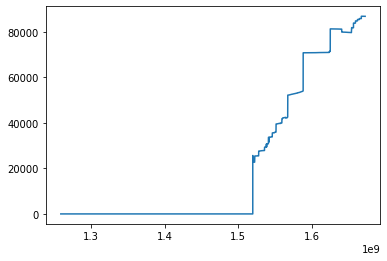

In [ ]:



plt.plot(df['created_utc'], df['subreddit_subscribers'].replace("None", 0))

In [ ]:
df['created_utc'] = pd.to_datetime(df['created_utc'])

In [ ]:
df['subreddit_subscribers'] = df['subreddit_subscribers'].replace('None', 0)

In [ ]:
df['subreddit_subscribers'] = df['subreddit_subscribers'].astype(int)

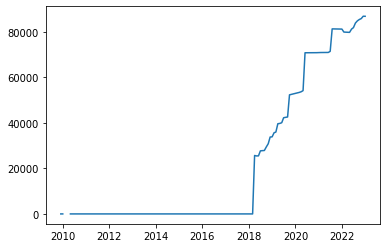

In [ ]:
plt.plot(df.drop_duplicates("created_utc").set_index("created_utc").resample('M')['subreddit_subscribers'].max())

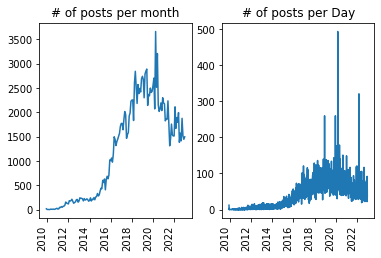

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].set_title("# of posts per month")
fig.autofmt_xdate(rotation=90)
ax[1].set_title("# of posts per Day")
ax[0].plot(df.drop_duplicates("created_utc").set_index("created_utc").resample('M').count()['title'])
ax[1].plot(df.drop_duplicates("created_utc").set_index("created_utc").resample('D').count()['title'])

In [ ]:
df['author'].value_counts()[:25]

[deleted]               43663
AutoModerator             871
Uwquatt                   628
IWannaREEEEEEEEEEEEE      505
supersonic63              441
NegativeBinomialM136      437
Derpalooza                396
MrPaninosSr               364
VerifiedPost              342
ghfsigiwaa                276
katsukichan               234
TheBioBoy                 223
Starlight-786             219
whyuwwhy                  205
UWGooseHunter             191
0x4b57x2002               188
jalebi_2000               187
tendstofortytwo           185
ClassIn30minutes          176
Deleriousmexican          172
UWboi                     164
TheGayArjun               153
microwavemasterrace       153
uwrallyx                  152
Integral-calculator       137
Name: author, dtype: int64

In [ ]:
import nltk
from tqdm import tqdm
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
tokenized_titles = df['title'].apply(nltk.word_tokenize)

In [ ]:
df[df['title'].apply(lambda x: 'MEGATHREAD' in x)][:50]

,author,selftext,subreddit_subscribers,title,url,created_utc
28918,math135bois,NaN,0,[STICKY] MATH135 FALL 2016 MIDTERM DISCUSSION ...,https://www.reddit.com/r/uwaterloo/comments/57...,2016-10-17 00:15:43
40454,uwRANTSTFU,"THIS SHIT IS SO USELESS, NEVER GOING TO USE AN...",0,FUCK WORK TERM REPORTS MEGATHREAD,https://www.reddit.com/r/uwaterloo/comments/68...,2017-04-28 02:23:18
41617,udontknowme1123,[removed],0,UNOFFICIAL SALT MEGATHREAD (WATERPOO) FOR APPL...,https://www.reddit.com/r/uwaterloo/comments/6b...,2017-05-16 03:17:01
96806,twofactorial,Hey folks. Use this thread for this term's Wat...,39807,SPRING 2019 CO-OP/WATERLOOWORKS MEGATHREAD // ...,https://www.reddit.com/r/uwaterloo/comments/bo...,2019-05-13 16:00:38
96861,[deleted],[deleted],39808,PRING 2019 RESUME CRITIQUE MEGATHREAD // MODER...,https://www.reddit.com/r/uwaterloo/comments/bo...,2019-05-13 23:55:35
96864,twofactorial,"As requested by the community, we will also ha...",39808,SPRING 2019 RESUME CRITIQUE MEGATHREAD,https://www.reddit.com/r/uwaterloo/comments/bo...,2019-05-13 23:58:15
107502,[deleted],[deleted],52308,FALL 2020 CO-OP/WATERLOOWORKS MEGATHREAD,https://www.reddit.com/r/uwaterloo/comments/d8...,2019-09-24 14:09:20
115858,[deleted],[deleted],52996,WINTER 2020 CO-OP/WATERLOOWORKS MEGATHREAD // ...,https://www.reddit.com/r/uwaterloo/comments/el...,2020-01-07 03:18:25
117218,mywaterlooaccount,Hey folks. Use this thread for this term's Wat...,53094,WINTER 2020 CO-OP/WATERLOOWORKS MEGATHREAD // ...,https://www.reddit.com/r/uwaterloo/comments/es...,2020-01-22 15:35:09
121429,Nowayhosay12345,[http://chng.it/NjxxJBYVCR](http://chng.it/Njx...,53516,END UNIVERSITIES AND COLLEGES ACROSS ONTARIO D...,https://www.reddit.com/r/uwaterloo/comments/fh...,2020-03-13 04:49:45


In [ ]:
comments_df = pd.read_csv('/content/uwaterloo_comments.csv', index_col=False)


In [ ]:
comments_df['created_utc'] = pd.to_datetime(comments_df['created_utc'])

In [ ]:
comments_df.head()

,id,link_id,author,body,created_utc
0,c0ggl42,t3_a7sdl,kineticflow,BSc (Rensselaer Polytechnic Institute)\n\nMSc ...,2009-11-30 04:41:33
1,c0ggl7p,t3_a7u3s,kineticflow,"BASc, MASc, PhD (Waterloo)\n\nC-C-C-COMBO NON-...",2009-11-30 04:43:12
2,c0ggl9h,t3_a7sfe,kineticflow,"BSc, MSc, PhD (Waterloo)",2009-11-30 04:44:08
3,c0gglaf,t3_a7u6r,pussymoney,"DUU DAAYY, WE R GOING TO TALK ABOUT MEEEEEEEAA...",2009-11-30 04:44:42
4,c0kj7vr,t3_b1nft,kineticflow,No.,2010-02-14 06:54:10


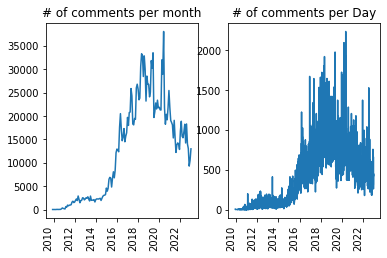

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].set_title("# of comments per month")
fig.autofmt_xdate(rotation=90)
ax[1].set_title("# of comments per Day")
ax[0].plot(comments_df.drop_duplicates("created_utc").set_index("created_utc").resample('M').count()['author'])
ax[1].plot(comments_df.drop_duplicates("created_utc").set_index("created_utc").resample('D').count()['author'])

In [ ]:
comments_df['author'].value_counts()[:25]

[deleted]               255574
AutoModerator            10950
honhonhonFRFR             9745
tendstofortytwo           9684
Deputy_Dan                8600
VerifiedPost              7331
microwavemasterrace       6763
beaverlyknight            6134
Tree_Boar                 6022
Frozen-Placenta           5991
Mr-Goose-                 5349
123Four5Six7              5052
Dabestfujiyoshi           5048
supersonic63              4997
AetherThought             4829
xhumptyDumptyx            4768
Low-monthly-payments      4537
UWGooseHunter             4331
christoffles              4105
ClassIn30minutes          3969
TheBioBoy                 3742
little_sae                3710
TheBalrogofMelkor         3533
boolgogi                  3514
angerygoosepopo           3457
Name: author, dtype: int64

# Set up pyspark

In [ ]:
import requests.auth

client_id = "jFkke_LszU_S_w9W8wgD8Q"
secret = "bEykE3G-QC85EIe-9b5icHNLk1fVAw"

username = "Ok_Mathematician713"
password = "szl99121"


client_auth = requests.auth.HTTPBasicAuth(client_id, secret)
post_data = {"grant_type": "password", "username": username, "password": password}
headers = {"User-Agent": "ChangeMeClient/0.1 by YourUsername"}
response = requests.post("https://www.reddit.com/api/v1/access_token", auth=client_auth, data=post_data, headers=headers)
response.json()


{'access_token': '1282280923885-gK_mhKMwK9ld_65-5QpcSX7onbjAPQ',
 'token_type': 'bearer',
 'expires_in': 86400,
 'scope': '*'}

In [ ]:
import praw
reddit = praw.Reddit(client_id=client_id, client_secret=secret, user_agent=headers["User-Agent"])

In [ ]:
from pmaw import PushshiftAPI
api = PushshiftAPI()

subs = [
    # 'mcmaster',
    # 'geegees',
    # 'uwo',
    # 'queensuniversity',
    # 'mcgill',
    # 'ubc',
    # 'uoft',
    'uwaterloo',
    # 'ualberta',
    # 'simonfraser',
    # 'uoguelph',
    # 'carletonu',
    # 'concordia',
    # 'wlu'
]

In [ ]:
 for comment in reddit.subreddit("uwaterloo").comments(limit=25):
   print(comment.author)
   print(comment.body)
   print(comment.submission.permalink)

In [ ]:
import datetime
import time 
from time import perf_counter


Current_Date = datetime.datetime.today()
Previous_Date = datetime.datetime.today() - datetime.timedelta(days=1)
previous_timestamp = int(time.mktime(Previous_Date.timetuple()))

In [ ]:
subs_map = {}
t1_start = perf_counter()
for sub in subs: 
  comments = api.search_comments(subreddit=sub, since=previous_timestamp)
  subs_map[sub] = comments
  print(f"Crawled {sub} with {len(comments)} comments")
t1_stop = perf_counter()
print(t1_stop - t1_start)

Crawled uwaterloo with 472 comments
14.63781390800068


In [ ]:
comments = [comment for comment in subs_map['uwaterloo']]

In [ ]:
import json
json.dumps({'uwaterloo': comments})

'{"uwaterloo": [{"subreddit_id": "t5_2rb5s", "author_is_blocked": false, "comment_type": null, "edited": false, "author_flair_type": "richtext", "total_awards_received": 0, "subreddit": "uwaterloo", "author_flair_template_id": "e330c3cc-fa97-11e0-9645-12313d18ad57", "id": "jdbyn60", "gilded": 0, "archived": false, "collapsed_reason_code": null, "no_follow": true, "author": "Stasi_1950", "send_replies": true, "parent_id": 42164519174, "score": 1, "author_fullname": "t2_5hu00hmd", "all_awardings": [], "body": "And my other foot was starting a business", "top_awarded_type": null, "author_flair_css_class": "mathematics", "author_patreon_flair": false, "collapsed": false, "author_flair_richtext": [{"e": "text", "t": "CS"}], "is_submitter": false, "gildings": {}, "collapsed_reason": null, "associated_award": null, "stickied": false, "author_premium": false, "can_gild": true, "link_id": "t3_11z0f3m", "unrepliable_reason": null, "author_flair_text_color": "light", "score_hidden": true, "permal

In [ ]:
for sub, response in subs_map.items():
  subs_map[sub] = [comment['body'] for comment in response]

In [ ]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
print(stopwords.words('english'))

for sub, comments in subs_map.items():
  tokenized_doc = []
  for comment in comments:
    tokenized_comments = nltk.word_tokenize(comment)
    tokenized_comments = [lemmatizer.lemmatize(token) for token in tokenized_comments if token not in stopwords.words('english') and token.isalpha()]
    tokenized_doc.append(tokenized_comments)
  subs_map[sub] = tokenized_doc


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
from gensim import corpora, models

dictionary = corpora.Dictionary(subs_map[sub]) # subs_map[sub] => List of (List of Str)
corpus = [dictionary.doc2bow(text) for text in subs_map[sub]]


In [ ]:
import gensim 

t1_start = perf_counter()
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word = dictionary, passes=20)
t1_stop = perf_counter()

print(t1_stop - t1_start)

15.46829609400038


XTerm

In [ ]:
ldamodel.get_document_topics(corpus)

In [ ]:
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

for sub, comments in subs_map.items():
  if sub == 'uwaterloo':
    vectorizer = TfidfVectorizer(stop_words="english")
    X = vectorizer.fit_transform(comments)
    for i in range(2, 9):
      kmeans = KMeans(n_clusters=i, random_state=0, n_init="auto")
      kmeans.fit(X)
      print(1 - silhouette_score(X, kmeans.labels_, metric="cosine"))
    
    break


0.9979600489226094
0.9972492253402885
0.9957015818437738
0.9932978926631175
0.9926696684276974
0.9941050251824816
0.9937781066861618


In [ ]:
X

<508x2592 sparse matrix of type '<class 'numpy.float64'>'
	with 5755 stored elements in Compressed Sparse Row format>

In [ ]:
import pandas as pd

df = pd.DataFrame({"comments": comments, "label":kmeans.labels_})
df[df['label'] == 2]

In [ ]:
for comment in comments:
  print(comment)

In [ ]:
mcmaster - 38k
ottawa - 25k
western - 26.7k
queens - 19.5k
mcgill - 51.4k
ubc - 85.4k
uoft - 97.1k
yorku - 34.3k
ualberta - 37.5k
sfu - 18.7k
guelph - 10.3k
carletonU - 23.7k
concordia - 32.2k
wlu - 16.6k

In [ ]:
import pandas as pd
import pyspark
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
# stuff we'll need for text processing
from nltk.corpus import stopwords
import re as re
from pyspark.ml.feature import CountVectorizer , IDF
# stuff we'll need for building the model

from pyspark.mllib.linalg import Vector, Vectors
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.mllib.clustering import LDA, LDAModel
# reading the data
# data = sqlContext.read.format("csv") \
#    .options(header='true', inferschema='true') \
#    .load(os.path.realpath("uwaterloo_comments.csv"))
data = spark.read.csv("uwaterloo_comments.csv", header=True)

/content/spark-3.3.2-bin-hadoop3/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
df = data.toDF('id','link_id','author','body')
df.show(30)

+--------------------+--------------------+--------------------+--------------------+
|                  id|             link_id|              author|                body|
+--------------------+--------------------+--------------------+--------------------+
|             c0ggl42|            t3_a7sdl|         kineticflow|BSc (Rensselaer P...|
|MSc (California I...|                null|                null|                null|
|PhD (University o...|           Berkeley)|                null|                null|
|  We have a winner."| 2009-11-30 04:41:33|                null|                null|
|             c0ggl7p|            t3_a7u3s|         kineticflow|BASc, MASc, PhD (...|
|C-C-C-COMBO NON-B...| 2009-11-30 04:43:12|                null|                null|
|             c0ggl9h|            t3_a7sfe|         kineticflow|BSc, MSc, PhD (Wa...|
|             c0gglaf|            t3_a7u6r|          pussymoney|DUU DAAYY, WE R G...|
|AND SILLY-CON WAF...| 2009-11-30 04:44:42|           

In [ ]:
df.createOrReplaceTempView("comments")

In [ ]:
# q1_results = spark.sql("select * from comments where author is not NULL and body is not NULL")
# q1_results.show(50)
q1_results = df.filter("body is not null").select('author','body')
q1_results.show(20)

+--------------------+--------------------+
|              author|                body|
+--------------------+--------------------+
|         kineticflow|BSc (Rensselaer P...|
|         kineticflow|BASc, MASc, PhD (...|
|         kineticflow|BSc, MSc, PhD (Wa...|
|          pussymoney|DUU DAAYY, WE R G...|
|         kineticflow|                 No.|
|      Sector_Corrupt|  Only occasionally.|
|          pussymoney|        jshli is gay|
|               pe2ny|        Hi Waterloo!|
|               jmair|           I am now.|
|             gw8t3st|That's what she s...|
|          xtirpation|well, can't guara...|
|             keatsta|              Hello.|
|          xtirpation|                 hey|
|               Elyot|My girlfriend tel...|
|            bgritzut|                 Hi,|
|          xtirpation|What about the ca...|
|           [deleted]|           [deleted]|
|          xtirpation|Yes, I went aroun...|
| not including th...| you get 50% off ...|
|      earthwormchuck|          

In [ ]:
comments_df = q1_results.withColumn("id", monotonically_increasing_id()).select('id', 'body')
comments_df.show()

+---+--------------------+
| id|                body|
+---+--------------------+
|  0|BSc (Rensselaer P...|
|  1|BASc, MASc, PhD (...|
|  2|BSc, MSc, PhD (Wa...|
|  3|DUU DAAYY, WE R G...|
|  4|                 No.|
|  5|  Only occasionally.|
|  6|        jshli is gay|
|  7|        Hi Waterloo!|
|  8|           I am now.|
|  9|That's what she s...|
| 10|well, can't guara...|
| 11|              Hello.|
| 12|                 hey|
| 13|My girlfriend tel...|
| 14|                 Hi,|
| 15|What about the ca...|
| 16|           [deleted]|
| 17|Yes, I went aroun...|
| 18| you get 50% off ...|
| 19|                  Yo|
+---+--------------------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import col, udf, monotonically_increasing_id
from pyspark.sql.types import StringType, ArrayType

stop_words = stopwords.words("english")

@udf(returnType=ArrayType(StringType()))
def preprocess(comment):
  tokenized_comments = nltk.word_tokenize(comment.lower())
  tokenized_comments = [lemmatizer.lemmatize(token) for token in tokenized_comments if token not in stopwords.words('english') and token.isalpha()]
  return tokenized_comments

preprocessed_comments_df = q1_results.withColumn("processed_comment", preprocess(col("body")))
preprocessed_comments_df = preprocessed_comments_df.withColumn("id", monotonically_increasing_id())
# preprocessed_comments_df.cache()

:

In [ ]:
# preprocessed_comments_df.show(10)
preprocessed_comments_df_2 = preprocessed_comments_df.filter("processed_comment is not null").select('processed_comment', 'id')
preprocessed_comments_df_2.limit(10).show(100)

+--------------------+---+
|   processed_comment| id|
+--------------------+---+
|[bsc, rensselaer,...|  0|
|[basc, masc, phd,...|  1|
|[bsc, msc, phd, w...|  2|
|[duu, daayy, r, g...|  3|
|                  []|  4|
|      [occasionally]|  5|
|        [jshli, gay]|  6|
|      [hi, waterloo]|  7|
|                  []|  8|
|              [said]|  9|
+--------------------+---+



In [ ]:
Vector = CountVectorizer(inputCol="processed_comment", outputCol="features")
model = Vector.fit(preprocessed_comments_df_2.limit(10))

In [ ]:
result = model.transform(preprocessed_comments_df_2.limit(10))

In [ ]:
result.show()

+--------------------+---+--------------------+
|   processed_comment| id|            features|
+--------------------+---+--------------------+
|[bsc, rensselaer,...|  0|(19,[1,3,7,11],[1...|
|[basc, masc, phd,...|  1|(19,[0,2,14,18],[...|
|[bsc, msc, phd, w...|  2|(19,[0,1,2,16],[1...|
|[duu, daayy, r, g...|  3|(19,[5,8,10,15,17...|
|                  []|  4|          (19,[],[])|
|      [occasionally]|  5|      (19,[9],[1.0])|
|        [jshli, gay]|  6|(19,[4,12],[1.0,1...|
|      [hi, waterloo]|  7|(19,[0,6],[1.0,1.0])|
|                  []|  8|          (19,[],[])|
|              [said]|  9|     (19,[13],[1.0])|
+--------------------+---+--------------------+



In [ ]:
from pyspark.ml.clustering import LDA

df = spark.createDataFrame([[1, Vectors.dense([0.0, 1.0])], [2, SparseVector(2, {0: 1.0})],], ["id", "features"])
df.show()
# result = result.select('id', 'vectors')

+---+-------------+
| id|     features|
+---+-------------+
|  1|    [0.0,1.0]|
|  2|(2,[0],[1.0])|
+---+-------------+



In [ ]:
result

DataFrame[processed_comment: array<string>, id: bigint, vectors: vector]

In [ ]:
lda = LDA(k=2, seed=1, optimizer="em")
lda.setMaxIter(10)
model = lda.fit(result)

In [ ]:
model.vocabSize()

19

In [ ]:
model.describeTopics().show(truncate=False)

+-----+-----------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                        |termWeights                                                                                                                                                                                                         |
+-----+-----------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[0, 1, 2, 7, 6, 4, 5, 15, 10, 12]  |[0.1396494043260726, 0.09540394160563852, 0.0767176912831052, 0.05108052723217834, 0.05080440820966796, 0.04768817898749924, 0.0476361340731525, 0.04659037736687398, 0.04608631406359086,

In [ ]:
model.topicsMatrix()

DenseMatrix(19, 2, [1.6074, 1.0981, 0.883, 0.486, 0.5489, 0.5483, 0.5848, 0.5879, ..., 0.4946, 0.4772, 0.5233, 0.562, 0.4637, 0.5964, 0.5748, 0.5934], 0)

# Read in csvs

In [ ]:
import pandas as pd
submissions_df = pd.read_csv("uwaterloo_submissions.csv", header=0)
comments_df = pd.read_csv("uwaterloo_comments.csv", header=0, index_col=False)

In [ ]:
comments_df.shape, submissions_df.shape

In [ ]:
data_path = "uwaterloo_submissions.csv"  # Replace with the path to your dataset
df_submissions_spark = spark.read.csv(data_path, header=True, inferSchema=True)
df_submissions_spark.filter("title is not null").show(truncate=False)

In [ ]:
from rake_nltk import Rake

r = Rake()

r.extract_keywords_from_text

<bound method Rake.extract_keywords_from_text of <rake_nltk.rake.Rake object at 0x7f83026dff10>>

## Test lambda function for extraction

In [ ]:
from pmaw import PushshiftAPI
import os



api = PushshiftAPI()

SUB = 'uwaterloo'

SCHEMA = 'ups,subreddit_id,subreddit,score,parent_id,link_id,id,gilded,edited,distinguished,created_utc,controversiality,body,author_flair_text,author_flair_css,author'
DEFAULT_SCHEMA_VALUES = 't3_nvs6a,,c3cwdro,,t1_c3ctwhr,2,1325397971,uwaterloo,,2,Readmymind,0,t5_2rb5s,"",0,False'
schema = SCHEMA.split(',')

DEFAULT_VALUES = '0,'

now = datetime.datetime.now()
yesterday = now - datetime.timedelta(days=1)
yesterday_end = yesterday.replace(hour=23, minute=59, second=59, microsecond=0)


if "DATE_FROM" not in os.environ:
  now = datetime.datetime.now()
  yesterday = now - datetime.timedelta(days=1)
  yesterday_end = yesterday.replace(hour=23, minute=59, second=59, microsecond=0)
  from_timestamp = int(time.mktime((yesterday_end - datetime.timedelta(days=1)).timetuple()))
  to_timestamp = int(time.mktime(yesterday_end.timetuple()))
# else:

print(from_timestamp, to_timestamp, (yesterday_end - datetime.timedelta(days=1)), yesterday_end)
# DATE_FROM = os.environ.get("DATE_FROM", yesterday_end)


comments_dict = {}
t1_start = time.perf_counter()
comments = api.search_comments(subreddit=SUB, since=from_timestamp, until=to_timestamp)
result = []
for comment in comments:
  line = {}
  for field in SCHEMA.split(','):
    print(comment)
    line[field] = comment[field]
    print(comment[field])
  break
    
  result.append(line)
print(f"Crawled {SUB} with {len(result)} comments")
comments_dict[SUB] = result
t1_stop = time.perf_counter()
print(t1_stop - t1_start)

1681084799 1681171199 2023-04-09 23:59:59 2023-04-10 23:59:59
{'subreddit_id': 't5_2rb5s', 'author_is_blocked': False, 'comment_type': None, 'edited': False, 'author_flair_type': 'text', 'total_awards_received': 0, 'subreddit': 'uwaterloo', 'author_flair_template_id': None, 'id': 'jfo3oxj', 'gilded': 0, 'archived': False, 'collapsed_reason_code': None, 'no_follow': True, 'author': 'negativekarma191', 'send_replies': True, 'parent_id': None, 'score': 1, 'author_fullname': 't2_vli5vkay', 'all_awardings': [], 'body': 'Death is inevitable. We are 1/4 done life (acording to the average life expectancy (80)). And we’re approaching the extinction of humanity one way or another (sun will soon burn then cover up the earth as it expands, or we’ll die like the other 99% of species that have existed) and we will be forgotten forever and our bloodlines will be gone forever. So nothing matters. You don’t matter. Gg xoxo :)', 'top_awarded_type': None, 'author_flair_css_class': None, 'author_patreon_f

KeyError: ignored

In [ ]:
DEFAULT_SCHEMA_VALUES

['ups',
 'subreddit_id',
 'subreddit',
 'score',
 'parent_id',
 'link_id',
 'id',
 'gilded',
 'edited',
 'distinguished',
 'created_utc',
 'controversiality',
 'body',
 'author_flair_text',
 'author_flair_css',
 'author']

In [ ]:
now = datetime.datetime.now()
yesterday = now - datetime.timedelta(days=1)
yesterday_end = yesterday.replace(hour=23, minute=59, second=59, microsecond=0)
int(time.mktime(yesterday_end.timetuple()))

1681171199

In [ ]:
yesterday_end - datetime.timedelta(days=1)

datetime.datetime(2023, 4, 9, 23, 59, 59)

In [ ]:
comments_dict['uwaterloo'][0]

In [ ]:
!pip install pmaw

# Load data

In [ ]:
import pandas as pd
submissions_df = pd.read_csv("uwaterloo_submissions.csv", header=0)
comments_df = pd.read_csv("uwaterloo_comments.csv", header=0, index_col=False)
# submissions_df = pd.read_csv("uwaterloo_submissions.csv", header=0, index_col=False)
submissions_df.shape
comments_df.shape

(1950688, 16)

In [ ]:
comments_df = comments_df.dropna(subset="body")

In [ ]:
submissions_df.head()[["created_utc", "author", "title"]]
comments_df.head()[["created_utc", "author", "body"]]

,created_utc,author,body
0,1259556093,kineticflow,"BSc (Rensselaer Polytechnic Institute)\n\nMSc (California Institute of Technology)\\n\nPhD (University of California, Berkeley)\n\n\nWe have a winner."
1,1259556192,kineticflow,"BASc, MASc, PhD (Waterloo)\n\nC-C-C-COMBO NON-BREAKER!"
2,1259556248,kineticflow,"BSc, MSc, PhD (Waterloo)"
3,1259556282,pussymoney,"DUU DAAYY, WE R GOING TO TALK ABOUT MEEEEEEEAAAA-TALS\nAND SILLY-CON WAFERS"
4,1266130450,kineticflow,No.


In [ ]:
# submissions_df = submissions_df.dropna(subset="selftext")[submissions_df.dropna(subset="selftext")['selftext'].apply(lambda x: '[deleted]' not in x and '[removed]' not in x)]
submissions_df['selftext'].count()
comments_df['created_utc'] = pd.to_datetime(comments_df['created_utc'], unit='s')

### subset of data only

In [ ]:
# data_2018_mask = (pd.to_datetime(submissions_df['created_utc']) > '2018-01-01') & (pd.to_datetime(submissions_df['created_utc']) < '2018-12-31')
submissions_data_subset = submissions_df[(pd.to_datetime(submissions_df['created_utc']) > '2012-01-01') & (pd.to_datetime(submissions_df['created_utc']) < '2023-01-01')]

data_subset_mask = (pd.to_datetime(comments_df['created_utc'], unit='s') > '2012-01-01') & (pd.to_datetime(comments_df['created_utc'], unit='s') < '2023-01-01')
comments_data_subset = comments_df[data_subset_mask]

In [ ]:
comments_data_subset.head(5)

,link_id,distinguished,id,author_flair_css_class,parent_id,ups,created_utc,subreddit,author_flair_text,score,author,controversiality,subreddit_id,body,gilded,edited
13318,t3_nvs6a,NaN,c3cwdro,NaN,t1_c3ctwhr,2.0,2012-01-01 06:06:11,uwaterloo,Chem Eng,2,Readmymind,0,t5_2rb5s,"Well, jobmine's still open for another month isn't it? As long as you have at least 3 months of working time it'll be fine.",0,False
13319,t3_nycln,NaN,c3cwge0,environment,t3_nycln,1.0,2012-01-01 06:18:34,uwaterloo,Somehow Employable MSc,1,Mackinstyle,0,t5_2rb5s,"I'm not sure about an MASc but I'm doing an MSc and here's basically what I'd advise:\n\nThe Master's level degree in terms of research is good but it's nothing overly outstanding. Don't fear having to find the best place to do it. You want to do that with your potential PhD. It's also good to spread your grad degrees among different Universities for a good breadth of experience. Some also say it makes your CV look better.\n\nIf this helps, then I'm glad. If it doesn't apply to the BASc-MASc world then I hope someone else can be of better help. :)",0,False
13320,t3_nycln,NaN,c3cwkbp,NaN,t1_c3cwge0,2.0,2012-01-01 06:36:12,uwaterloo,NaN,2,SantiClaws,0,t5_2rb5s,"Thanks for the quick reply, it was definitely helpful. \n\nI guess I'm not determined enough to take the leap into research. It's something I can picture myself doing, but I don't know if I will feel the same way after a couple of years. How do you like it so far and do you plan on getting a PhD? \n\nA side question: what do you think about taking a year off to do a research internship? I may have an opportunity to do industrial research for 16 months, but it's a huge commitment.",0,False
13321,t3_nvs6a,NaN,c3cwn2h,NaN,t1_c3cwdro,1.0,2012-01-01 06:49:07,uwaterloo,NaN,1,[deleted],0,t5_2rb5s,"Yes, but I doubt there will be as many openings. And I don't want to depend on Jobmine as my only option.",0,False
13322,t3_nycln,NaN,c3cwoxl,environment,t1_c3cwkbp,1.0,2012-01-01 06:57:42,uwaterloo,Somehow Employable MSc,1,Mackinstyle,0,t5_2rb5s,"I'm liking it a ton. There is a certain joy from discovering/developing new things, highly specializing your knowledge of a set of topics, becoming an expert of sorts. The challenge I'm having that many people have is that it's not like work or undergrad with a structured schedule. I started my MSc and basically have 1 due date two years later and have to make sure I stick to that (because your advisor won't... they're 10x busier than you.)\n\nI'm not sure I can answer your side question with any sort of accuracy. I strongly recommend you talk to your undergrad advisor. Their job (and joy) is to chat with you about your options and give you an informed opinion. My opinion is ill-informed when it comes to research internships.",0,False


In [ ]:
test_comment_df = comments_data_subset.head(200).reset_index(drop=True)
test_comment_df['body'] = ['foo, bar'] * 200
test_comment_df['ups'] = test_comment_df['ups'].astype(int)
test_comment_df['created_utc'] = test_comment_df['created_utc'].apply(lambda x: int(time.mktime(x.timetuple())))
test_comment_df.to_csv('test_comments_2.csv', index=False)

In [ ]:
submissions_data_subset.shape, comments_data_subset.shape

((184521, 28), (1937311, 16))

In [ ]:
data_subset = pd.concat([
    comments_data_subset[["created_utc", "author", "body", "score", "link_id", "id"]].rename(columns={"body": "text"}), 
    submissions_data_subset[['selftext', 'created_utc', 'author', "score", "permalink", "id"]].rename(columns={"selftext": "text", "id": "link_id"}),
    submissions_data_subset[['title', 'created_utc', 'author', 'score', "permalink", "id"]].rename(columns={"title": "text", "id": "link_id"})
    ], axis=0)

# data_2018.head(15)[["created_utc", "author", "title"]]

In [ ]:
is_title = np.hstack((np.zeros(comments_data_subset.shape[0], dtype=np.uint8),
          np.zeros(submissions_data_subset.shape[0], dtype=np.uint8),
          np.ones(submissions_data_subset.shape[0], dtype=np.uint8)))
is_title.shape

(2306353,)

In [ ]:
data_subset['is_title'] = pd.Series(is_title).values

In [ ]:
data_subset['created_utc'] = pd.to_datetime(data_subset['created_utc'])

In [ ]:
data_subset['link_id'] = data_subset['link_id'].apply(lambda x: x.split("_")[-1])

In [ ]:
submissions_df.columns

Index(['subreddit_subscribers', 'url', 'edited', 'num_comments', 'over_18',
       'link_flair_text', 'permalink', 'link_flair_css_class', 'score',
       'is_self', 'id', 'selftext', 'media', 'media_embed', 'domain',
       'distinguished', 'created_utc', 'subreddit', 'subreddit_id',
       'thumbnail', 'title', 'author_flair_text', 'author_flair_css_class',
       'author', 'stickied', 'secure_media_embed', 'secure_media', 'gilded'],
      dtype='object')

In [ ]:
joined_df = data_subset.merge(submissions_df[['id', 'title', 'permalink']], how="left", left_on="link_id", right_on="id")

In [ ]:
submissions_df[submissions_df['author'] == 'Kitchen-Ad-766']

,subreddit_subscribers,url,edited,num_comments,over_18,link_flair_text,permalink,link_flair_css_class,score,is_self,...,subreddit_id,thumbnail,title,author_flair_text,author_flair_css_class,author,stickied,secure_media_embed,secure_media,gilded


In [ ]:
a = joined_df[joined_df['permalink_y'].isna()]
a['title'] = a['id_x']
a
# df[['a','b']].fillna(value=0)

<ipython-input-244-5f11216da8d9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['title'] = a['id_x']


,created_utc,author,text,score,link_id,id_x,permalink_x,is_title,id_y,title,permalink_y
1843418,2022-05-30 00:33:37,JoeUnderscoreUgly,"I enjoy the summer, but mostly bc it is the best time to bike.\n\nI much prefer the winter overall BC it is just so pretty!",4,v0o6t2,iahlwlc,NaN,0,NaN,iahlwlc,NaN
1843421,2022-05-30 00:40:13,AutoModerator,"AutoModerator thinks you're asking about residence. Check out [our FAQ on residence](https://www.reddit.com/r/uwaterloo/wiki/residence). Please do not message the moderators regarding this question.\n\n---\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/uwaterloo) if you have any questions or concerns.*",1,v0oco3,iahmn75,NaN,0,NaN,iahmn75,NaN
1843425,2022-05-30 00:45:36,AutoModerator,"AutoModerator thinks you're asking about admissions. Check out [our current admissions megathread](https://www.reddit.com/r/uwaterloo/comments/ubcvpa/admissions_high_school_megathread_fall_2022/), or alternatively, [our prior megathreads](https://www.reddit.com/r/uwaterloo/wiki/admissions) for further research. Please do not message the moderators regarding this question.\n\n---\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/uwaterloo) if you have any questions or concerns.*",1,v0oftw,iahn9bn,NaN,0,NaN,iahn9bn,NaN
1843427,2022-05-30 00:48:20,LouieSiemens,"Very few people are into hardware, but it teaches you to problem solve",3,v0oftw,iahnkky,NaN,0,NaN,iahnkky,NaN
1843431,2022-05-30 00:54:11,LouisV12,"Yes but I think more people are willing to leave the big 4 after co-op 1/2, or skip it all together to pursue opportunities in finance",6,v0of8p,iaho8fe,NaN,0,NaN,iaho8fe,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1846468,2022-06-04 03:39:36,start-studying,"Just deactivated the key fob, but bring it back to icon or turnkey anyways pls because we could recycle it!",1,v0prh8,ib42p93,NaN,0,NaN,ib42p93,NaN
1847012,2022-06-05 22:04:23,Arvania-2020,"Wait :,) what do u mean by this? There’s no LLC for AFM for first years 2022-2023",1,v26qyz,ibasfmk,NaN,0,NaN,ibasfmk,NaN
1847398,2022-06-06 19:53:22,murvs,Assignments were long but they actually guide you through the processes. Doing PLAN 381 rn and I kinda miss the guidance.\n\nDoing the gis and decision support specialization for planning,2,v2bzgr,ibeknhu,NaN,0,NaN,ibeknhu,NaN
1879001,2022-08-04 09:04:10,jainnyy,Heyy what are the chances of an international student getting into a pharmd program in MUN or University of Saskatchewan if you don't mind me asking,1,v0qnnf,iiw6ng9,NaN,0,NaN,iiw6ng9,NaN


In [ ]:
data_subset.tail()

,created_utc,author,text,score,link_id,id,permalink,is_title
185570,2022-12-31 17:43:32,menexploitmen,Suggest a plan for ECE MASc part time,1,zzzeo6,NaN,/r/uwaterloo/comments/zzzeo6/suggest_a_plan_for_ece_masc_part_time/,1
185571,2022-12-31 17:49:50,QUITIG,Math Finance PMATH Courses,14,zzzji4,NaN,/r/uwaterloo/comments/zzzji4/math_finance_pmath_courses/,1
185572,2022-12-31 17:53:49,Awkward-Thanks5374,Co-op earnings based on 1A grades,0,zzzmpd,NaN,/r/uwaterloo/comments/zzzmpd/coop_earnings_based_on_1a_grades/,1
185573,2022-12-31 18:57:34,Living-Midnight-961,Non degree term,4,100106t,NaN,/r/uwaterloo/comments/100106t/non_degree_term/,1
185575,2022-12-31 21:41:36,TheKoalaFromMars,Wholesome things about UWaterloo this year.,703,1004erm,NaN,/r/uwaterloo/comments/1004erm/wholesome_things_about_uwaterloo_this_year/,1


In [ ]:
data_subset.count()

created_utc    2147881
author         2147881
text           2147881
score          2147881
link_id        2147881
id             1937311
permalink       210570
is_title       2147881
dtype: int64

In [ ]:
data_subset.tail()

,created_utc,author,text,score,link_id,id,permalink,is_title
185570,2022-12-31 17:43:32,menexploitmen,Suggest a plan for ECE MASc part time,1,zzzeo6,NaN,/r/uwaterloo/comments/zzzeo6/suggest_a_plan_for_ece_masc_part_time/,1
185571,2022-12-31 17:49:50,QUITIG,Math Finance PMATH Courses,14,zzzji4,NaN,/r/uwaterloo/comments/zzzji4/math_finance_pmath_courses/,1
185572,2022-12-31 17:53:49,Awkward-Thanks5374,Co-op earnings based on 1A grades,0,zzzmpd,NaN,/r/uwaterloo/comments/zzzmpd/coop_earnings_based_on_1a_grades/,1
185573,2022-12-31 18:57:34,Living-Midnight-961,Non degree term,4,100106t,NaN,/r/uwaterloo/comments/100106t/non_degree_term/,1
185575,2022-12-31 21:41:36,TheKoalaFromMars,Wholesome things about UWaterloo this year.,703,1004erm,NaN,/r/uwaterloo/comments/1004erm/wholesome_things_about_uwaterloo_this_year/,1


## All data

In [ ]:
all_data = pd.concat([
    comments_df[["created_utc", "author", "body", "score"]].rename(columns={"body": "text"}), 
    submissions_data[['selftext', 'created_utc', 'author', "score"]].rename(columns={"selftext": "text"})
    ], axis=0)

# data_2018.head(15)[["created_utc", "author", "title"]]

In [ ]:
all_data.count()

created_utc    2056498
author         2056498
text           2056498
score          2056498
dtype: int64

In [ ]:
all_data.head()

,created_utc,author,text,score
0,2009-11-30 04:41:33,kineticflow,BSc (Rensselaer Polytechnic Institute)\n\nMSc ...,1
1,2009-11-30 04:43:12,kineticflow,"BASc, MASc, PhD (Waterloo)\n\nC-C-C-COMBO NON-...",1
2,2009-11-30 04:44:08,kineticflow,"BSc, MSc, PhD (Waterloo)",1
3,2009-11-30 04:44:42,pussymoney,"DUU DAAYY, WE R GOING TO TALK ABOUT MEEEEEEEAA...",1
4,2010-02-14 06:54:10,kineticflow,No.,1


In [ ]:
-------------------+----------------------------------------------------------------------------+
|datetime           |title                                                                       |
+-------------------+----------------------------------------------------------------------------+
|2018-01-01 00:18:35|ADHD Diagnosis??                                                            |
|2018-01-01 01:57:54|Do term averages get rounded up?                                            |
|2018-01-01 02:28:25|I realllly dont want to start the new year off by failing a course          |
|2018-01-01 02:51:26|MATH 127 :(                                                                 |
|2018-01-01 02:58:15|H A P P Y N E W Y E A R M Y D U D E S                                       |
|2018-01-01 03:26:04|Looking for some advice on trying to be more productive and manage time well|
|2018-01-01 05:02:35|Happy New Year my dude!                                                     |
|2018-01-01 05:09:27|THANKS MR GOOSE                                                             |
|2018-01-01 05:19:21|Icon open on New Year's?                                                    |
|2018-01-01 05:38:07|NIGGER                                                                      |
+-------------------+----------------------------------------------------------------------------+

### Preprocess functions

In [ ]:
import gc
gc.collect()

100

In [ ]:
import string, re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from tqdm import tqdm

_ = StopWordsRemover() 
stopwords = _.getStopWords()
stopwords_set = set(stopwords) | set(stop_words)  #| set(gazeteers)
print(len(stopwords_set))
non_space_whitespace = string.whitespace.replace(" ", "")

def remove_punctuation_and_tokenize(text):
    # Remove punctuation
    cleaned_text = text.lower().translate(str.maketrans('', '', string.punctuation))
    # cleaned_text = cleaned_text.translate(str.maketrans('', '', string.digits))
    cleaned_text = re.sub(f"[{non_space_whitespace}]", " ", cleaned_text)
    
    # Tokenize (split by whitespace)
    tokens = cleaned_text.split()
    
    return tokens

def filter_words(words):
  filtered_tokens = []
  for w in words:
    if (w not in stopwords_set and 
        len(w) >= 1):
      filtered_tokens.append(w)
  if len(filtered_tokens) < 1:
    filtered_tokens.append('none')
  return filtered_tokens


corpus = [
     'This is the first document.',
     'This document is the second document.',
     'And this is the third one.',
     'Is this the first document?',
 ]

# custom_modified_corpus = list(tqdm(map(lambda x: filter_words(remove_punctuation_and_tokenize(x)), comments_df['body'])))

# vectorizer = CountVectorizer()
# X = vectorizer.fit_transform(corpus)
# X

211


In [ ]:
"you" in stopwords_set

True

### Process corpus for subset data

In [ ]:
# processed_corpus = list(tqdm(map(lambda x: filter_words(remove_punctuation_and_tokenize(x)), data_2018['title'])))
# processed_corpus = list(tqdm(map(lambda x: filter_words(remove_punctuation_and_tokenize(x)), pd.concat([submissions_df['title'], selftext_col], axis=0))))

processed_corpus = list(tqdm(map(lambda x: filter_words(remove_punctuation_and_tokenize(x)), data_subset['text'])))

2147881it [01:13, 29330.55it/s]


In [ ]:
len(processed_corpus)

2147881

In [ ]:
len(processed_corpus)

2042596

In [ ]:
list(filter(lambda x: "don't" in x, processed_corpus))

[]

### Process corpus for all data

In [ ]:
processed_corpus = list(tqdm(map(lambda x: filter_words(remove_punctuation_and_tokenize(x)), all_data['text'])))

2056498it [01:08, 29815.89it/s]


In [ ]:
len(processed_corpus) 

2056498

## Previous LDA stuff

In [ ]:
t1_start = perf_counter()
dictionary = corpora.Dictionary(processed_corpus)
corpus = [dictionary.doc2bow(text) for text in processed_corpus]
t1_stop = perf_counter()
print(t1_stop - t1_start)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


6.977946629000144


In [ ]:
import itertools as it


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
len(list(it.chain(*processed_corpus)))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


870923

In [ ]:
vectorizer = TfidfVectorizer()
t1_start = perf_counter()
X_comments = vectorizer.fit_transform(list(map(' '.join, processed_corpus)))
# X_title = vectorizer.fit_transform(list(map(' '.join, processed_corpus)))
# X = vectorizer.fit_transform([' '.join(list(it.chain(*processed_corpus)))])
t1_stop = perf_counter()
print(t1_stop - t1_start)

vectorizer.get_feature_names_out()

7.387005485999907


array(['00', '000', '0000', ..., 'ﾉಥ益ಥ', 'ﾟஇ', 'ﾟヮﾟ'], dtype=object)

In [ ]:
len(vectorizer.get_feature_names_out())

129848

In [ ]:
X_title.shape

(29521, 16408)

In [ ]:
vectorizer.idf_

array([10.59974385,  9.90659667, 10.59974385, ..., 10.59974385,
       10.59974385, 10.59974385])

In [ ]:
mean_tfidf = np.squeeze(np.array(np.mean(X, axis=0)))
# mean_tfidf = np.squeeze(np.asarray(np.true_divide(X.sum(axis=0), (X != 0).sum(axis=0))))
top_n_ind = (-mean_tfidf).argsort()[:20]
top_n_ind

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([ 12476,  26088,  57633,  43057,  27718, 113081, 103343,  26715,
        64619,  62567,  67748,  26813,  47479,  75781, 116383, 110622,
       100350, 100253,  72725,  39803])

In [ ]:
mean_tfidf[top_n_ind]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([0.01548791, 0.01441228, 0.01212063, 0.01199837, 0.01158865,
       0.01155288, 0.01102844, 0.01032172, 0.01011915, 0.00971838,
       0.00850799, 0.00845124, 0.00767794, 0.00729827, 0.0072072 ,
       0.00714391, 0.00697354, 0.00696093, 0.00682168, 0.00679696])

In [ ]:
idf_mapping = pd.Series(vectorizer.vocabulary_, name="index").reset_index().join(pd.Series(vectorizer.idf_, name="idf").reset_index(), on="index", lsuffix="left").sort_values(by="idf")


In [ ]:
idf_mapping.head()

,level_0,indexleft,index,idf
41,anyone,1596,1596,3.910767
157,coop,3881,3881,4.158000
57,waterloo,15773,15773,4.312815
106,cs,4146,4146,4.315610
4,get,6646,6646,4.399235


In [ ]:
percentile = 0.00
trimmed_idf = idf_mapping[(idf_mapping['idf'] > idf_mapping['idf'].quantile(percentile)) & (idf_mapping['idf'] < idf_mapping['idf'].quantile(1 - percentile))]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
idf_mapping[idf_mapping['idf'] > idf_mapping['idf'].quantile(0.001)].head(50)

In [ ]:
# log(N / (df(t) + 1)
idf_mapping.head(50)

In [ ]:
from itertools import compress
masked_data = list(compress(corpus, data_2018_mask))
len(masked_data)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


29521

# Attempt to group by week

In [ ]:
# data_2018_tokens = pd.concat([data_2018.reset_index(drop=True), pd.Series(processed_corpus, name="tokens").reset_index(drop=True)], axis=1)[['created_utc', 'tokens', 'title', 'author', 'score', 'num_comments']]
data_subset_tokens = pd.concat([data_subset.reset_index(drop=True), pd.Series(processed_corpus, name="tokens").reset_index(drop=True)], axis=1)[['created_utc', 'tokens', 'text', 'author', 'score']]
data_subset_tokens['created_utc'] = pd.to_datetime(data_subset_tokens['created_utc'])
data_subset_tokens['day'] = data_subset_tokens['created_utc'].dt.dayofyear

In [ ]:
reference_date = pd.Timestamp('2012-01-01')
data_subset_tokens['day'] = (data_subset_tokens['created_utc'] - reference_date).dt.days
print(reference_date)
data_subset_tokens['week_index'] = (data_subset_tokens['created_utc'] - reference_date).dt.days // 7

2012-01-01 00:00:00


In [ ]:
data_subset_tokens.groupby('day')['created_utc'].min()

day
0      2012-01-01 06:06:11
1      2012-01-02 00:24:48
2      2012-01-03 00:09:34
3      2012-01-04 00:09:02
4      2012-01-05 00:05:42
               ...        
4013   2022-12-27 00:01:21
4014   2022-12-28 00:03:26
4015   2022-12-29 00:00:45
4016   2022-12-30 00:00:29
4017   2022-12-31 00:00:34
Name: created_utc, Length: 4018, dtype: datetime64[ns]

In [ ]:
data_subset_tokens.groupby('week_index').count()['text']

week_index
0       463
1       419
2       455
3       664
4       589
       ... 
569    2734
570    3585
571    3479
572    3324
573    3042
Name: text, Length: 574, dtype: int64

In [ ]:
data_subset_tokens.groupby('week_index')['created_utc'].min()

week_index
0     2012-01-01 06:06:11
1     2012-01-08 00:05:05
2     2012-01-15 00:22:41
3     2012-01-22 00:30:03
4     2012-01-29 00:08:37
              ...        
569   2022-11-27 00:03:56
570   2022-12-04 00:10:17
571   2022-12-11 00:04:41
572   2022-12-18 00:00:42
573   2022-12-25 00:00:05
Name: created_utc, Length: 574, dtype: datetime64[ns]

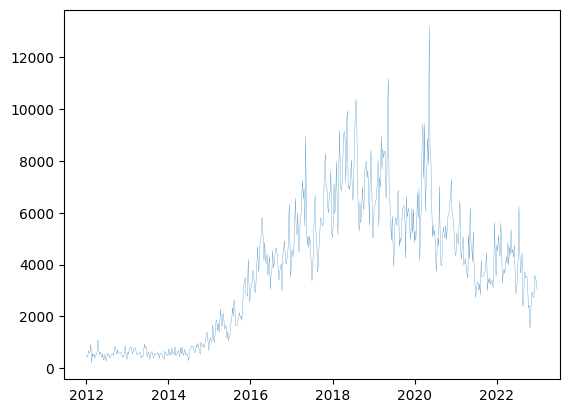

In [ ]:
day_reindex = data_subset_tokens.groupby('week_index')['created_utc'].min()
plt.plot(
  day_reindex,
  data_subset_tokens.groupby('week_index').count()['text'], linewidth=0.2
)


In [ ]:
day_reindex.shape

(574,)

## Attempt to group by day (all data)

In [ ]:
# data_2018_tokens = pd.concat([data_2018.reset_index(drop=True), pd.Series(processed_corpus, name="tokens").reset_index(drop=True)], axis=1)[['created_utc', 'tokens', 'title', 'author', 'score', 'num_comments']]
all_data_tokens = pd.concat([all_data.reset_index(drop=True), pd.Series(processed_corpus, name="tokens").reset_index(drop=True)], axis=1)[['created_utc', 'tokens', 'text', 'author', 'score']]
all_data_tokens['created_utc'] = pd.to_datetime(all_data_tokens['created_utc'])


In [ ]:
reference_date = all_data_tokens['created_utc'].min()

# Calculate the day index
all_data_tokens['day_index'] = (all_data_tokens['created_utc'] - reference_date).dt.days

In [ ]:
all_data_tokens

,created_utc,tokens,text,author,score,day_index
0,2009-11-30 04:41:33,"[bsc, rensselaer, polytechnic, institute, msc,...",BSc (Rensselaer Polytechnic Institute)\n\nMSc ...,kineticflow,1,0
1,2009-11-30 04:43:12,"[basc, masc, phd, waterloo, ccccombo, nonbreaker]","BASc, MASc, PhD (Waterloo)\n\nC-C-C-COMBO NON-...",kineticflow,1,0
2,2009-11-30 04:44:08,"[bsc, msc, phd, waterloo]","BSc, MSc, PhD (Waterloo)",kineticflow,1,0
3,2009-11-30 04:44:42,"[duu, daayy, going, talk, meeeeeeeaaaatals, si...","DUU DAAYY, WE R GOING TO TALK ABOUT MEEEEEEEAA...",pussymoney,1,0
4,2010-02-14 06:54:10,[none],No.,kineticflow,1,76
...,...,...,...,...,...,...
2056493,2022-12-31 17:43:32,"[pursuing, masc, part, time, working, full, ti...",I am pursuing an MASc Part time while working ...,menexploitmen,1,4779
2056494,2022-12-31 17:49:50,"[pmath, 333, 351, 450, 451, required, math, fi...","PMATH 333, 351, 450, 451 are required for the ...",QUITIG,14,4779
2056495,2022-12-31 17:53:49,"[got, last, 1a, final, grades, quest, today, c...",I just got my last 1A final grades in on Quest...,Awkward-Thanks5374,0,4779
2056496,2022-12-31 18:57:34,"[possible, take, non, degree, term, upcoming, ...",Is it possible to take a non degree term this ...,Living-Midnight-961,4,4779


In [ ]:
day_reindex = all_data_tokens.groupby('day_index')['created_utc'].min()
plt.plot(
    day_reindex,
    all_data_tokens.groupby('day_index').count()['text'],
    linewidth=0.2
)


In [ ]:
X.shape

(2042596, 8889105)

## Aggregate all tokens for each day and fit tfidf

In [ ]:
B = csr_matrix((1, 8889105))
B.shape

(1, 8889105)

In [ ]:
day_reindex.count()

4018

In [ ]:
X.shape[1]

8889105

In [ ]:
data_subset_tokens.shape

In [ ]:
# aggs_by_col = {'Reviews': [non_nan_mean], 
#                'Price': [non_nan_mean,standard_deviation],
#                'User Rating': [mean_lower_rating]}
# ex1 = ex.agg(aggs_by_col)

tokens_by_day = data_subset_tokens.groupby('week_index').agg({'tokens': [lambda x: list(it.chain(*x))]}).values
tokens_by_day = list(map(lambda x: x[0], tokens_by_day))

## Vectorizer

In [ ]:
def identity_tokenizer(text):
    return text

In [ ]:


# vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, stop_words='english', lowercase=False, ngram_range=(1, 2))
# t1_start = perf_counter()
# X = vectorizer.fit_transform(data_subset_tokens['tokens'])
# # X = vectorizer.fit_transform([' '.join(list(it.chain(*processed_corpus)))])
# t1_stop = perf_counter()
# print(t1_stop - t1_start)

vectorizer = CountVectorizer(tokenizer=identity_tokenizer, stop_words='english', lowercase=False, ngram_range=(1, 2))
t1_start = perf_counter()
X = vectorizer.fit_transform(data_subset_tokens['tokens'])
# X = vectorizer.fit_transform([' '.join(list(it.chain(*processed_corpus)))])
t1_stop = perf_counter()
print(t1_stop - t1_start)

len(vectorizer.get_feature_names_out())

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn(


188.00681272199995


8959497

In [ ]:
with open("/content/CountVectorizer.pkl", 'wb') as fout:
  pickle.dump(vectorizer, fout)

In [ ]:
save_npz('/count_vectorizer_comments_selftext_body.npz', X)

In [ ]:
# Comments + selftext + body since 2012-01-01
# 152.55814807099887
# 8889105

In [ ]:
X = load_npz('/content/count_vectorizer_comments_selftext_body.npz')

In [ ]:
with open('/content/CountVectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

In [ ]:
vectorizer.stop_words

'english'

In [ ]:
vectorizer.vocabulary_.get('well', None)

## Aggregate comment-level tfidf over week

(num_comments, num_features) -> (num_weeks, num_features)

In [ ]:
# group_sizes = [len(group[0]) for group in day_index_groupby]

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix, vstack
from tqdm import tqdm

day_indices = data_subset_tokens.reset_index()['week_index'].values
X_grouped = [X[np.where(day_indices == i)] for i in tqdm(np.unique(day_indices))]

stacked_X_grouped = vstack(X_grouped)

# group_means = np.array([np.mean(group, axis=0) for group in X_grouped])
# A = csr_matrix(np.vstack(group_means))


100%|██████████| 574/574 [00:03<00:00, 181.65it/s]


In [ ]:
X

<2147881x8959497 sparse matrix of type '<class 'numpy.int64'>'
	with 48143474 stored elements in Compressed Sparse Row format>

In [ ]:
t1_start = perf_counter()
group_means = [csr_matrix(group.sum(axis=0)) for group in tqdm(X_grouped)]
t1_end = perf_counter()
# group_means = np.array([np.mean(group, axis=0) for group in X_grouped])
print(t1_end - t1_start)

100%|██████████| 574/574 [01:13<00:00,  7.77it/s]

73.85685045300124


In [ ]:
stacked_X_grouped = vstack(group_means)

In [ ]:
stacked_X_grouped

<574x8959497 sparse matrix of type '<class 'numpy.int64'>'
	with 25681926 stored elements in Compressed Sparse Row format>

In [ ]:
(stacked_X_grouped.data.nbytes + stacked_X_grouped.indptr.nbytes + stacked_X_grouped.indices.nbytes) / (1000 * 1000)

308.185412

In [ ]:
# selftext + body only over weeks from 2012-01-01
# <574x8889105 sparse matrix of type '<class 'numpy.int64'>'
#	with 25437119 stored elements in Compressed Sparse Row format>
# 305 mbs

In [ ]:
# idf_mapping = pd.Series(vectorizer.vocabulary_, name="index").reset_index().join(pd.Series(vectorizer.idf_, name="idf").reset_index(), on="index", lsuffix="left").sort_values(by="idf")
# idf_mapping = idf_mapping.set_index("index").drop(columns="indexleft")

In [ ]:
number_of_terms_above_k = np.sum(stacked_X_grouped.sum(axis=0) >= 200)
top_word_counts_indices = np.squeeze(np.array(stacked_X_grouped.sum(axis=0).argsort()[:, -number_of_terms_above_k:]))[::-1]
print(number_of_terms_above_k, top_word_counts_indices)


16187 [4597186 2402110 3978019 ...  109333 2400024 8865112]


In [ ]:
# vectorizer.vocabulary_
inverse_vocabulary_ = {v:k for (k, v) in vectorizer.vocabulary_.items()}

In [ ]:
for i in vectorizer.idf_.argsort()[:20]:
  print(vectorizer.idf_[i], inverse_vocabulary_[i])

In [ ]:
len(inverse_vocabulary_)

8889105

In [ ]:
top_k_indices = []
for row in range(X.shape[0]):
    row_data = X.getrow(row)
    top_k_indices_row = np.argsort(row_data.data)[-X.shape[1]:][::-1]  # Get indices of the top k values in descending order
    relative_top_k_indices_row = row_data.indices[top_k_indices_row]   # Convert relative indices to original indices
    top_k_indices.append((top_k_indices_row, relative_top_k_indices_row))

len(top_k_indices)



4018

## Analyze variances

In [ ]:
moment_2 = np.mean(stacked_X_grouped.multiply(stacked_X_grouped), axis=0)
mean = np.mean(stacked_X_grouped, axis=0) 
mean_squared = np.multiply(mean, mean)
X_var = np.squeeze(np.array(moment_2) - np.array(mean_squared))
X_var.shape

(8889105,)

In [ ]:
X_var[1241384]

15.709927278466399

In [ ]:
sorted_X_var = X_var.argsort()[::-1]

In [ ]:
X_var[sorted_X_var[200]]

802.9142668965258

In [ ]:
top_variances = sorted_X_var[0:20]
X_var[top_variances]

array([592827.87468586, 582415.07680377, 193236.66037283, 188316.42376683,
       187589.26387354, 187238.22202831, 100090.31320339,  73211.58328072,
        59398.36115529,  51751.66911095,  44846.88824679,  31445.32510107,
        27697.86868846,  23007.0859577 ,  21870.11984181,  21161.66989098,
        21032.50629788,  19563.22248662,  16074.93667521,  15706.49342896])

In [ ]:
# idf_mapping.loc[top_variances]['level_0'].values
for i in top_variances:
  print(inverse_vocabulary_[i])

penis
penis penis
fuck
pd
fuck pd
pd fuck
like
dont
people
im
deleted
think
know
good
really
cs
time
youre
want
got


In [ ]:
"don’t"

'don’t'

## Plot multiple trends

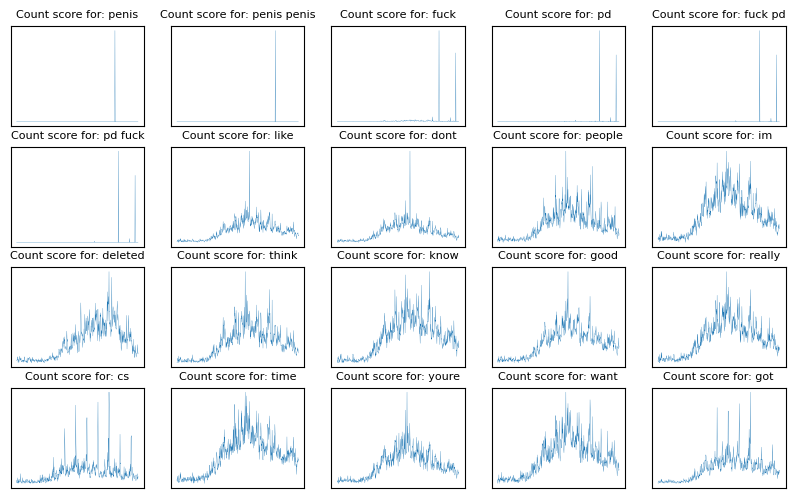

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6), nrows=4, ncols=5)
for i in range(4):
  for j in range(5):
    matrix_index = top_variances.reshape(4, 5)[i][j]
    # ax[i][j].set_title(f"TFIDF score for: {idf_mapping.loc[matrix_index]['level_0']}", fontsize=8)
    ax[i][j].set_title(f"Count score for: {inverse_vocabulary_[matrix_index]}", fontsize=8)
    # ax[i][j].yaxis.label.set_visible(False)
    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])
    ax[i][j].set(ylabel=None)
    ax[i][j].plot(
        np.expand_dims(np.arange(stacked_X_grouped.shape[0]), axis=-1),
        stacked_X_grouped[:, matrix_index].todense(), linewidth=0.2)

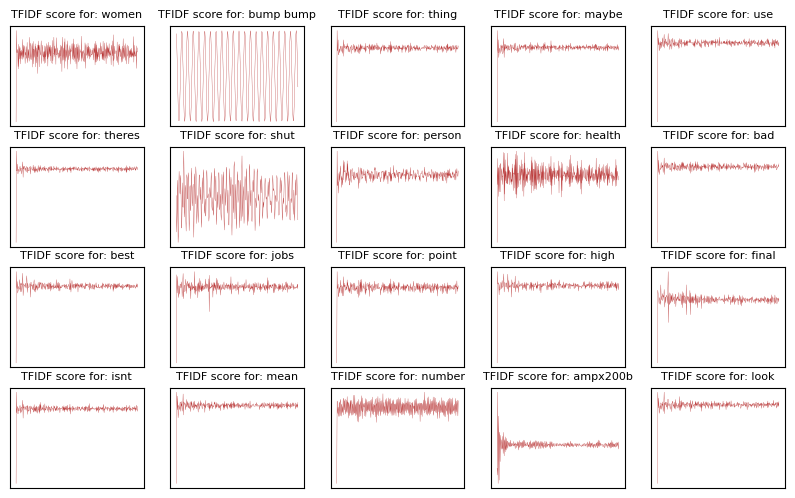

In [ ]:
from scipy.fft import fft

fig, ax = plt.subplots(figsize=(10, 6), nrows=4, ncols=5)
for i in range(4):
  for j in range(5):
    matrix_index = top_variances.reshape(4, 5)[i][j]
    series = stacked_X_grouped[:, matrix_index].toarray().reshape(-1)
    # ax[i][j].set_title(f"TFIDF score for: {idf_mapping.loc[matrix_index]['level_0']}", fontsize=8)
    ax[i][j].set_title(f"TFIDF score for: {inverse_vocabulary_[matrix_index]}", fontsize=8)
    # ax[i][j].yaxis.label.set_visible(False)
    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])
    ax[i][j].set(ylabel=None)
    # ax[i][j].plot(
    #     np.expand_dims(np.arange(stacked_X_grouped.shape[0]), axis=-1),
    #     series, linewidth=0.2)
    # ax[i][j].set_ylim([0, series.max()])
    ax[i][j].plot(
        np.expand_dims(np.arange(364), axis=-1),
        fft(series)[1:365], linewidth=0.2, color="firebrick")

In [ ]:
def thresholding_algo(y, lag, threshold, influence, min_occurrences=25):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = np.zeros(len(y))
    stdFilter = np.zeros(len(y))
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1] and y[i] > min_occurrences:
            if y[i] > (avgFilter[i-1]):
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))


In [ ]:
%%timeit
thresholding_algo(series, ma_window_size, 10, 0.5, min_occurrences=50)

29.1 ms ± 4.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Plot one trend

In [ ]:
# inverse_vocabulary_[i]
# vectorizer.vocabulary_

In [ ]:
a = list(filter(lambda x: x[1] > top_trend_quantile, top_trend_contributions))

[(inverse_vocabulary_[i[0]], i[1]) for i in a]

1.0
total count: 301


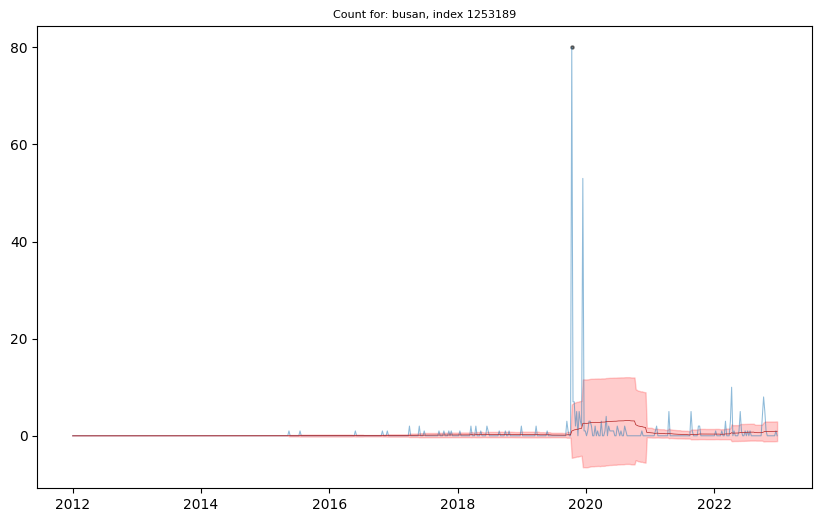

In [ ]:
# (cmh, nrb), (feds, wusa), (jobmine, waterlooworks)
# matrix_index = idf_mapping[idf_mapping['level_0'] == 'exam'].index[0]
matrix_index = vectorizer.vocabulary_["busan"]
series = stacked_X_grouped[:, matrix_index].toarray().reshape(-1)
ma_window_size = 52

peak_detection = thresholding_algo(series, ma_window_size, 10, 0.5, min_occurrences=50)


# moving_average = np.convolve(series, np.ones(ma_window_size)/ma_window_size, mode='valid')
# moving_std = np.array([np.std(series[i:i+ma_window_size]) for i in range(len(series) - ma_window_size + 1)])

expanding_mean = np.divide(np.cumsum(series), np.arange(1, stacked_X_grouped.shape[0] + 1))
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title(f"Count for: {inverse_vocabulary_[matrix_index]}, index {matrix_index}", fontsize=8)
# ax.set_ylim([0, 0.2])
# ax.plot(day_reindex, series, linewidth=0.3)
ax.plot(day_reindex, series, linewidth=0.75, alpha=0.5)
# ax.plot(day_reindex, expanding_mean, linewidth=1)
ax.plot(day_reindex, peak_detection['avgFilter'], linewidth=0.5, color="firebrick")
ax.fill_between(day_reindex, 
                peak_detection['avgFilter'] - peak_detection['stdFilter'],
                peak_detection['avgFilter'] + peak_detection['stdFilter'], color='r', alpha=0.2)

# ax.axhline(y = 1.96 * np.std(series), color="black")
# ax.axhline(y = np.mean(series) - 1.96 * np.std(series), color="purple")

# import ruptures as rpt
# algo = rpt.Pelt(model="rbf").fit(rolling_average.values)
# bkpts = algo.predict(pen=20)

# for pt in bkpts[:-1]:
#   ax.axvline(x=day_reindex[pt])



print(np.sum(peak_detection['signals']))
ax.scatter(day_reindex[peak_detection['signals'].astype(bool)],
           series[peak_detection['signals'].astype(bool)], s=5, color="black", alpha=0.5)

print(f"total count: {np.sum(series)}")
# at least x times a day, 

In [ ]:
stacked_X_grouped / np.sum(stacked_X_grouped, axis=0)

In [ ]:
day_reindex[np.where(peak_detection['signals'])[0]].values, np.where(peak_detection['signals'])[0], series[np.where(peak_detection['signals'])[0]]

(array(['2014-01-26T00:17:26.000000000', '2014-11-30T00:11:28.000000000',
        '2015-02-01T00:00:02.000000000', '2015-06-28T00:05:29.000000000',
        '2015-07-05T00:24:36.000000000', '2017-01-29T00:01:50.000000000',
        '2017-10-15T00:00:55.000000000', '2018-09-02T00:00:26.000000000',
        '2018-12-16T00:01:23.000000000', '2019-01-27T00:05:46.000000000',
        '2019-05-26T00:00:08.000000000'], dtype='datetime64[ns]'),
 array([108, 152, 161, 182, 183, 265, 302, 348, 363, 369, 386]),
 array([ 59,  71, 109,  74, 170, 147,  68,  78, 115, 366, 112]))

In [ ]:
peak_detection['avgFilter'][240:260]

array([21.  , 20.25, 20.75, 25.75, 21.25, 18.75, 18.5 , 26.25, 40.75,
       53.75, 70.25, 75.75, 98.75, 91.25, 82.5 , 69.75, 41.25, 32.75,
       28.25, 24.5 ])

In [ ]:
peak_detection['stdFilter'][240:260]

array([11.18033989, 10.63896142, 10.56823069,  4.38035387,  4.86698058,
        3.69966215,  3.64005494, 16.69393602, 23.54118731, 21.0638909 ,
       10.66243406,  6.05702072, 38.09445498, 45.45533522, 49.04334817,
       55.07438152,  9.8836987 , 18.77997604, 16.06821396, 17.81151313])

### timeseries techniques

In [ ]:
print(bkpts), len(rolling_average.values), len(day_reindex)

[270, 571]


(None, 571, 574)

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


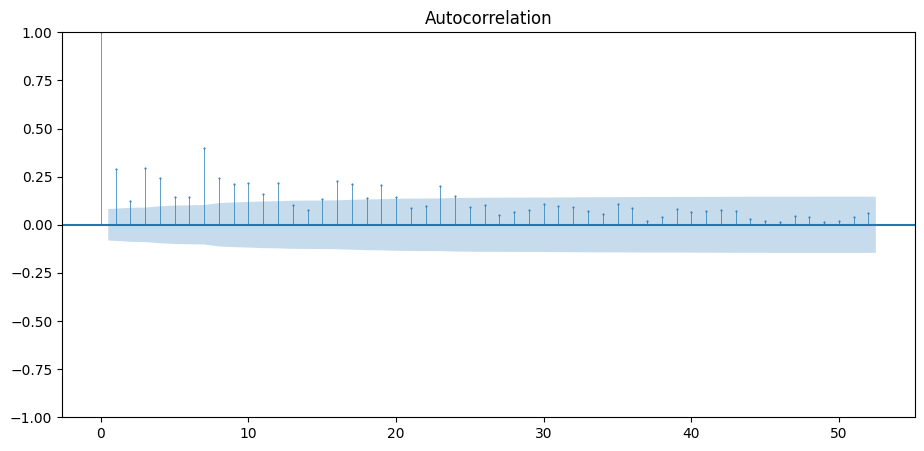

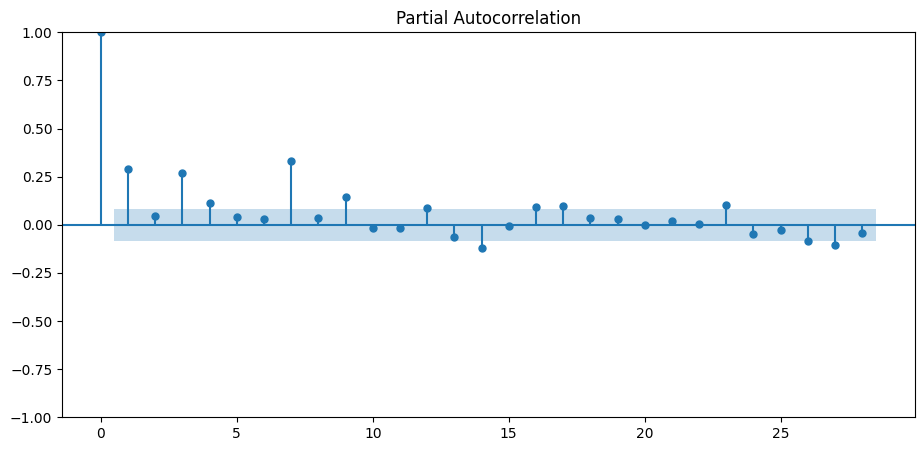

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot autocorrelation
plt.rc("figure", figsize=(11,5))
plot_acf(series, lags=52, markersize=0.5, vlines_kwargs={"linewidth": 0.5})
plot_pacf(series)
plt.show()


### Decomposition

In [ ]:
import scipy.stats

scipy.stats.norm.ppf(0.999999)

4.753424308817087

In [ ]:
[(inverse_vocabulary_[i[0]], i[1][3]) for i in decompose_results.items()]

19.415991328331444 0.10001762885721362
70.54367771651425


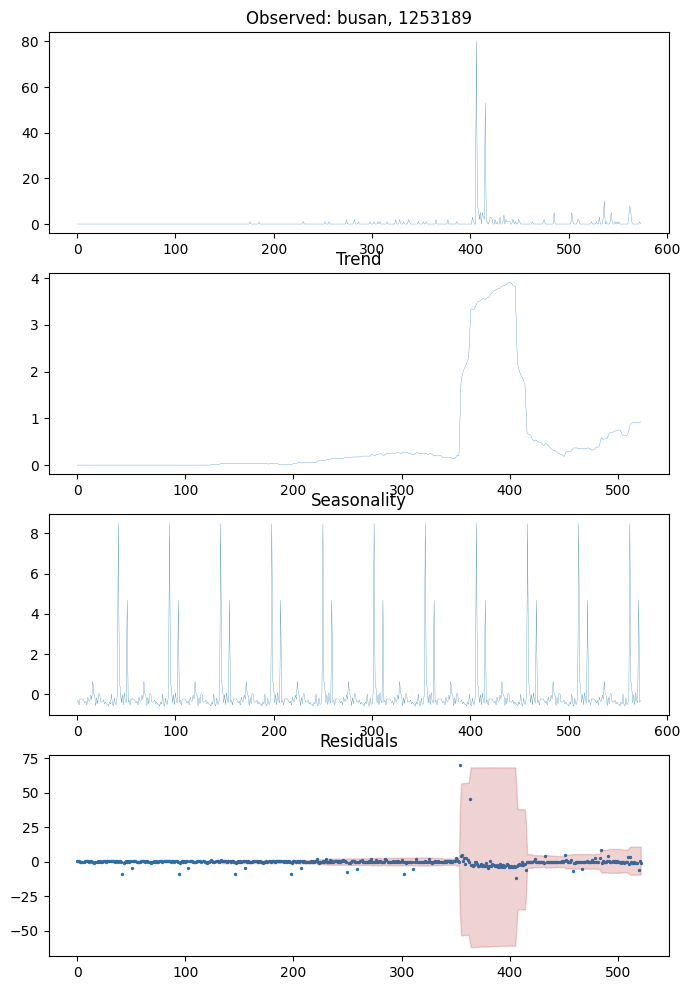

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL


matrix_index = vectorizer.vocabulary_['busan']
series = stacked_X_grouped[:, matrix_index].toarray().reshape(-1)

# fig = decomposition.plot()
decomposition = seasonal_decompose(series, two_sided=False, model='additive', period=52)
decomposition_sq = seasonal_decompose(series ** 2, two_sided=False, model='additive', period=52)
# decomposition = STL(series, period=52).fit()
trend, seasonal, resid = decomposition.trend[~np.isnan(decomposition.trend)], decomposition.seasonal[~np.isnan(decomposition.seasonal)], decomposition.resid[~np.isnan(decomposition.resid)]
trend_sq, seasonal_sq, resid_sq = decomposition_sq.trend[~np.isnan(decomposition_sq.trend)], decomposition_sq.seasonal[~np.isnan(decomposition_sq.seasonal)], decomposition_sq.resid[~np.isnan(decomposition_sq.resid)]

std_band = np.sqrt(trend_sq - trend ** 2)
fig, ax = plt.subplots(figsize=(8, 12), nrows=4, ncols=1)
ax[0].set_title(f"Observed: {inverse_vocabulary_[matrix_index]}, {matrix_index}")
ax[0].plot(series, linewidth=0.2)

ax[1].set_title(f"Trend")
ax[1].plot(trend, linewidth=0.2)
ax[2].set_title(f"Seasonality")
ax[2].plot(seasonal, linewidth=0.2)
ax[3].set_title(f"Residuals")

transformed_resid = resid
# ax[3].axhline(np.mean(transformed_resid), color="firebrick", alpha=0.5)
# ax[3].axhline(np.mean(transformed_resid) + 5 * np.std(transformed_resid), color="firebrick", linestyle="dashed", alpha=0.5)
ax[3].scatter(np.arange(resid.shape[0]), transformed_resid, s=2)
ax[3].fill_between(np.arange(resid.shape[0]), 
                trend - 5 * std_band,
                trend + 5 * std_band, color='firebrick', alpha=0.2)



sum_variances = np.var(decomposition.trend[~np.isnan(decomposition.trend)]) + np.var(decomposition.seasonal) + np.var(decomposition.resid[~np.isnan(decomposition.resid)])
var_seasonal = np.var(decomposition.seasonal)
var_trend = np.var(decomposition.trend[~np.isnan(decomposition.trend)])
var_resid = np.var(decomposition.resid[~np.isnan(decomposition.resid)])

print(sum_variances, var_seasonal / sum_variances)
print(resid[resid.argmax()])



In [ ]:
transformed_data, optimal_lambda = scipy.stats.boxcox(resid - min(resid) + 0.001)
transformed_data, optimal_lambda = scipy.stats.yeojohnson(resid)
optimal_lambda

0.9462343736317826

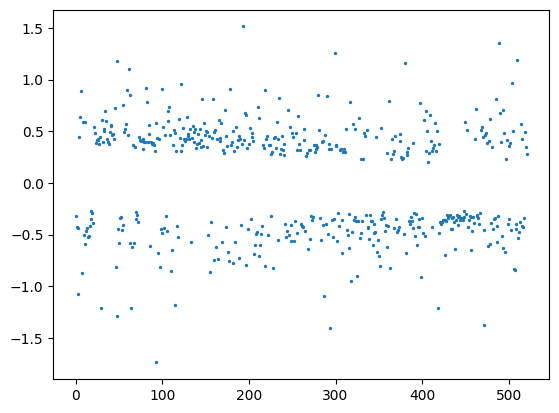

In [ ]:
plt.scatter(np.arange(resid.shape[0]), 1/np.cbrt(resid), s=2)

In [ ]:
-27 ** (1/3)

-3.0

ShapiroResult(statistic=0.9229269623756409, pvalue=1.062817872820004e-15)

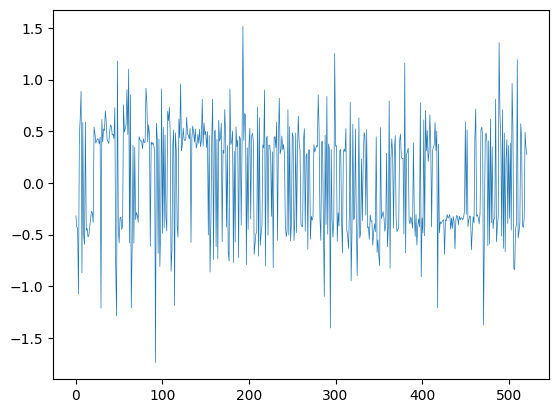

In [ ]:
from scipy.stats import fligner, shapiro

def split_array(array, k):
    n = len(array)
    split_indices = np.linspace(0, n, k+1, dtype=int)
    sequences = [array[split_indices[i]:split_indices[i+1]] for i in range(k)]
    return sequences

# series = stacked_X_grouped[:, 4560725].toarray().reshape(-1)
# plt.plot(series)
# transformed_resid =  (resid - min(resid) + 0.01) ** 0.5 - 1 / (0.5)
transformed_data = 1/(np.cbrt(resid))
plt.plot(transformed_data, linewidth=0.5)
# plt.hist(transformed_data)
fligner(*split_array(transformed_data, 5))
shapiro(transformed_data)

# (y + lambda_2)^(lambda_1) - 1 / lambda_1

In [ ]:
np.var(series), np.mean(series)

(100983.26782223894, 429.09581881533103)

### Analyze proportion of variance in seasonal component to sum of variances

In [ ]:
stacked_X_grouped[:, top_word_counts_indices]

<574x15950 sparse matrix of type '<class 'numpy.int64'>'
	with 4333599 stored elements in Compressed Sparse Row format>

In [ ]:
stacked_X_grouped.sum(axis=0)[0, 4550932]

501

In [ ]:
inverse_vocabulary_[4550932]

'life sci'

In [ ]:
np.argmax(series)

318

### Decompose the top occuring words

In [ ]:
np.sum(stacked_X_grouped, axis=0)[:, 8865112]

matrix([[200]])

In [ ]:
# plt.hist()
np.asarray(list(map(lambda x: x[1][3], decompose_results.items()))).sum() / np.asarray(list(map(lambda x: x[1][3], decompose_results.items()))).shape[0]

0.5936507936507937

In [ ]:
top_word_counts_indices.shape

(16187,)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

top_seasonal_contributions, top_trend_contributions, top_resid_contributions, outliers = {}, {}, {}, {}
decompose_results = {}
outliers_count = 0
count = 0
resid_std_threshold, min_counts = 5, 50
for index, i in tqdm(enumerate(top_word_counts_indices)):
  print('\n')
  # print(f"Decomposing: {(inverse_vocabulary_[i])}, {index}")
  matrix_index = i
  series = stacked_X_grouped[:, matrix_index].toarray().reshape(-1)
  decomposition = seasonal_decompose(series, two_sided=False, model='additive', period=52)
  decomposition_sq = seasonal_decompose(series ** 2, two_sided=False, model='additive', period=52)

  trend, seasonal, resid = decomposition.trend[~np.isnan(decomposition.trend)], decomposition.seasonal[~np.isnan(decomposition.seasonal)], decomposition.resid[~np.isnan(decomposition.resid)]
  # trend_sq, seasonal_sq, resid_sq = decomposition_sq.trend[~np.isnan(decomposition_sq.trend)], decomposition_sq.seasonal[~np.isnan(decomposition_sq.seasonal)], decomposition_sq.resid[~np.isnan(decomposition_sq.resid)]
  # print(trend_sq, trend)
  # std_band = np.sqrt(trend_sq - trend ** 2)

  # decomposition = STL(series, period=52).fit()
  sum_variances = np.var(trend) + np.var(seasonal) + np.var(resid)
  ratio_season = np.var(seasonal) / sum_variances
  ratio_trend = np.var(trend) / sum_variances
  ratio_resid = np.var(resid) / sum_variances
  # print(f"Seasonality ratio: {ratio}")
  # print("\n")
  
  top_seasonal_contributions[i] = ratio_season
  top_trend_contributions[i] = ratio_trend
  top_resid_contributions[i] = ratio_resid

  # plt.plot(resid)
  # print(trend.shape)
  # print(std_band.shape)
  # plt.plot(trend)
  # plt.fill_between(np.arange(resid.shape[0]), 
  #               resid - 10 * std_band,
  #               resid + 10 * std_band, color='firebrick', alpha=0.2)

  mask = np.multiply((resid > (np.mean(resid) + resid_std_threshold * np.std(resid))), (resid > min_counts))

  result = [ratio_season, ratio_trend, ratio_resid, np.where(mask)[0]]
  decompose_results[i] = result
  if np.sum(mask) > 0:
    print(decompose_results[i], outliers_count, outliers_count / (index + 1))
    outliers_count += 1
  # print(resid[resid.argmax()])
  # print(np.mean(resid) + 5 * np.std(resid))
  # print(decompose_results[i], outliers_count, outliers_count / (index + 1))




### Save results

In [ ]:
with open("/content/greater_200_std_5_trending_words.pkl", 'wb') as fout:
  pickle.dump(decompose_results, fout)

In [ ]:
with open("/content/greater_200_std_5_trending_words.pkl", 'rb') as f:
  decompose_results = pickle.load(f)

In [ ]:
# decompose_results

In [ ]:
top_seasonal_contributions = sorted(top_seasonal_contributions.items(), key=lambda x: x[1], reverse=True)
top_trend_contributions = sorted(top_trend_contributions.items(), key=lambda x: x[1], reverse=True)
top_resid_contributions = sorted(top_resid_contributions.items(), key=lambda x: x[1], reverse=True)

In [ ]:
[(inverse_vocabulary_[i[0]], i[1]) for i in top_seasonal_contributions[302:402]]

In [ ]:

top_seasonal_quantile = np.quantile(list(map(lambda x: x[1], top_seasonal_contributions)), 0.99)
print(len(list(filter(lambda x: x[1] > top_seasonal_quantile, top_seasonal_contributions))))

top_trend_quantile = np.quantile(list(map(lambda x: x[1], top_trend_contributions)), 0.99)
print(len(list(filter(lambda x: x[1] > top_trend_quantile, top_trend_contributions))))

71
71


### Get top words with bursts in trend

In [ ]:
len(list(filter(lambda x: len(x[1][3]) > 0, decompose_results.items())))

1031

In [ ]:
trending_topics = [(k, v[3]) for k, v in decompose_results.items() if len(v[3]) > 0]
sorted_trending_topics = sorted(trending_topics, key=lambda x: x[1][0])

In [ ]:
from tables.leaf import toarray
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(0, len(sorted_trending_topics), 5):
  print(i)
  for j in sorted_trending_topics[i:i + 5]:
    indexed_date = j[1] + 52
    time_series = stacked_X_grouped[:, j[0]].toarray().reshape(-1)
    ax.plot(day_reindex, time_series, linewidth=1, alpha=0.5, label=f"{inverse_vocabulary_[j[0]]}")
    ax.scatter(day_reindex[indexed_date], time_series[indexed_date], s=5)
    for x,y in zip(day_reindex[indexed_date], time_series[indexed_date]):
      corr = -0.05 # adds a little correction to put annotation in marker's centrum
      ax.annotate(x.strftime('%Y-%m-%d'),  xy=(x, y + 2.5), fontsize=8)

  ax.set_title(f"Topics appearing from {day_reindex[sorted_trending_topics[i:i + 5][0][1][0] + 52].strftime('%Y-%m-%d')} to {day_reindex[sorted_trending_topics[i:i+5][-1][-1][-1] + 52].strftime('%Y-%m-%d')}", fontsize=8)
  ax.legend()
  fname = day_reindex[sorted_trending_topics[i][1][0] + 52].strftime('%Y-%m-%d')
  fname = fname + '_' + '_'.join([leg_text._text for leg_text in ax.get_legend().texts])
  print(f"Saving {fname}")
  plt.savefig(f"/content/Plots_3/{fname}.png")
  ax.clear()
  
# ax.set_ylim([0, 0.2])

# ax.plot(day_reindex, series, linewidth=0.3)





In [ ]:
plt.plot(stacked_X_grouped[:, vectorizer.vocabulary_['kaybe west']])

In [ ]:
p = [(inverse_vocabulary_[i[0]], i[1] + 52) for i in sorted_trending_topics][2]
p

('board', array([ 74, 354, 363, 369]))

In [ ]:
%%timeit
X[:, 2972179]

659 ms ± 146 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit 
csc_X[:, 2972179]

278 µs ± 105 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
from scipy.sparse import csc_matrix
csc_X = csc_matrix(X)

In [ ]:
csc_X[:, 2972179].indices, csc_X[:, 2972179].data

(array([     21,    1314,    2173, ..., 2147660, 2147817, 2147823],
       dtype=int32),
 array([1, 1, 1, ..., 1, 1, 1]))

In [ ]:
np.array(list(map(lambda x: x[0], sorted_trending_topics)))

array([8113540, 2972179, 1111167, ..., 2332782, 3583395, 6067516])

In [ ]:
csc_X[:, 2972179]

stacked_X_grouped[:, 2972179]

<574x1 sparse matrix of type '<class 'numpy.int64'>'
	with 536 stored elements in Compressed Sparse Row format>

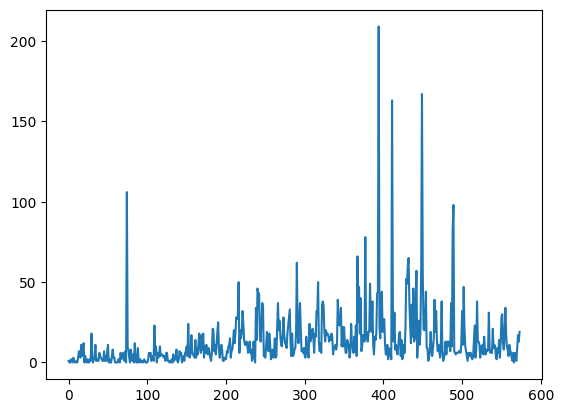

In [ ]:
plt.plot(stacked_X_grouped[:, 2972179].toarray())

In [ ]:
df_for_token = data_subset.iloc[csc_X[:, 2972179].indices]
df_for_token['link_id'].apply(lambda x: x.split('_')[-1]).value_counts()



1ftagq    36
8j7xrk    27
cgd1ye    26
hd8g91    26
ndzm7n    24
          ..
9f0nyd     1
9fl9gs     1
9fms4u     1
9frv7w     1
ztwmri     1
Name: link_id, Length: 3397, dtype: int64

In [ ]:
data_subset.columns

Index(['created_utc', 'author', 'text', 'score', 'link_id', 'id', 'permalink',
       'is_title', 'week_index'],
      dtype='object')

In [ ]:
data_subset.iloc[csc_X[:, 2972179].indices]

,created_utc,author,text,score,link_id,id,permalink,is_title,week_index
13339,2012-01-02 05:23:13,sriyegna,"Thanks for the reply. Im planning on doing it, but how beneficial is it? How much would it cover of your residence + education fees?",1,t3_nzf0k,c3d5hmp,NaN,0,0
14632,2012-01-23 18:35:44,andechs,WEEF is amazing and helps fund many student teams at Waterloo. At least the fund is student run and you can see exactly where the money is going... unlike the non-refundable FEDS fees,2,t3_oskfj,c3ju2u9,NaN,0,3
15491,2012-02-02 19:37:34,yerich,"Not feasible since to gain legitimacy and members, you need to run services/office/events and to do that you'll need money and to do that you'll need to have fees collected on your behalf by Feds/Admin... and that's not going to happen.\n\nWhy do you dislike a society so much that you'd consider this course of action? It would be like not liking the Conservatives so much that you start you own government and try to get the Queen to recognize you. Wouldn't it be better to just try to change things in the existing system?",3,t3_p82ax,c3n9ejl,NaN,0,4
16404,2012-02-13 05:13:05,NobullNoble,"You should care about Feds (and in part my candidacy) for three reasons. 1) It affects your student life now, 2) You pay for it, and 3) It'll affect your future life.\n\n1. The following are things that you may not of known Feds runs, oversees or manages that *directly affect students' lives*:\n\n- [Negotiating](http://www.therecord.com/news/local/article/663811--grt-wants-more-money-from-students) the bus pass. \n- Negotiating your health and dental plan (currently one of the best in Canada)\n- Insurance provider, resource manager, and service provider to each society (SciSoc, AHSUM, etc)\n- Oversees and resources over 160 clubs (varying from 10 people to 800 people, cultural, religious, interest-based and more. It's one of the main areas of community on our campus.)\n- Main advocate to the University. Examples in the last year:\n 1) pushing for student consultation in regards to O-week changes, \n 2) pushing for [teaching chairs](http://www.ousa.ca/2011/12/07/teaching-chairs-a-tangible-step-toward-improving-teaching-quality-on-ontario-campuses-%E2%80%93-by-natalie-cockburn-december-7-2011/) to improve quality of teaching\n 3) pushing for a weekly Wednesday break from 4:30-6pm to allow for events to occur without class conflicts. \n- Currently runs O-week\n- Provide a student voice on issues via Council &amp; Senate\n- Advocates to the government on behalf of students. As an example many believe the tuition grant ($800) is because of pressure from OUSA (an association of Universities which uWaterloo is a part of) over the past few years.\n- Run campus wide events. Like Lights concert, Epic Meal Time and Welcome Week.\n- Run services like GLOW, Student Food Bank, Campus Response Team (amazingly trained first aid people that help at events), Off-campus Dons (1/3 of First Years live off-campus), the International Student Connection and [more](http://feds.ca/clubs-services-and-societies/services-listing) \n- Runs Bomber, Campus Bubble, Feds Used Book Store, the Fed Bus and more\n\nThe idea that Feds only affects 1% of students is pure BS. Whether it's the low cost bus pass, one of the many student clubs, the safest bar night in town, the cost of your tuition or simply the friends you made during O-week - the decisions made by Feds have in some way or another impacted your life whether you know it or not.\n\n2) You pay two fees each term. There's an administration fee which covers the Upass and the Health &amp; Dental plan. Plus there's the services fee which covers all the staffing and most of the things listed above.\n\nYoue money goes towards this - by voting you get to have your say in where that money can go. There are other opportunities within Feds as well to get your voice heard. We are proposing a text service to allow students to share their uWaterloo problems with us so that we can speak better to stu

In [ ]:
submissions_df

,subreddit_subscribers,url,edited,num_comments,over_18,link_flair_text,permalink,link_flair_css_class,score,is_self,...,subreddit_id,thumbnail,title,author_flair_text,author_flair_css_class,author,stickied,secure_media_embed,secure_media,gilded
17,0,https://www.reddit.com/r/uwaterloo/comments/bpoio/hello_world/,False,4,False,None,/r/uwaterloo/comments/bpoio/hello_world/,None,1,True,...,t5_2rb5s,self,"Hello, world",ECE12,engineering,kineticflow,False,{},None,0
18,0,https://www.reddit.com/r/uwaterloo/comments/bpw5h/so/,False,9,False,None,/r/uwaterloo/comments/bpw5h/so/,None,2,True,...,t5_2rb5s,self,So...,alum,alum,xtirpation,False,{},None,0
19,0,https://www.reddit.com/r/uwaterloo/comments/bqb58/three_of_my_coworkers_have_started_a_quest_to_eat/,False,10,False,None,/r/uwaterloo/comments/bqb58/three_of_my_coworkers_have_started_a_quest_to_eat/,None,8,True,...,t5_2rb5s,self,Three of my coworkers have started a quest to eat at \r\nand review every restaurant in the University Plaza,None,None,keatsta,False,{},None,0
23,0,https://www.reddit.com/r/uwaterloo/comments/bx3u2/wtf_man_found_naked_bleeding_in_waterloo_phone/,1272439429.0,2,False,None,/r/uwaterloo/comments/bx3u2/wtf_man_found_naked_bleeding_in_waterloo_phone/,None,4,True,...,t5_2rb5s,self,"[WTF] Man found naked, bleeding in Waterloo phone booth",Pure Math/Economics,NaN,G_Wen,False,{},None,0
33,0,https://www.reddit.com/r/uwaterloo/comments/ciakp/good_isps_in_waterloo/,False,9,False,None,/r/uwaterloo/comments/ciakp/good_isps_in_waterloo/,None,5,True,...,t5_2rb5s,self,Good ISPs in Waterloo?,None,None,fusterclut,False,{},None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185570,86866,https://www.reddit.com/r/uwaterloo/comments/zzzeo6/suggest_a_plan_for_ece_masc_part_time/,False,1,False,Advice,/r/uwaterloo/comments/zzzeo6/suggest_a_plan_for_ece_masc_part_time/,advice,1,True,...,t5_2rb5s,self,Suggest a plan for ECE MASc part time,None,None,menexploitmen,False,{},None,0
185571,86866,https://www.reddit.com/r/uwaterloo/comments/zzzji4/math_finance_pmath_courses/,False,4,False,None,/r/uwaterloo/comments/zzzji4/math_finance_pmath_courses/,None,14,True,...,t5_2rb5s,self,Math Finance PMATH Courses,None,None,QUITIG,False,{},None,0
185572,86866,https://www.reddit.com/r/uwaterloo/comments/zzzmpd/coop_earnings_based_on_1a_grades/,False,22,False,None,/r/uwaterloo/comments/zzzmpd/coop_earnings_based_on_1a_grades/,None,0,True,...,t5_2rb5s,self,Co-op earnings based on 1A grades,None,None,Awkward-Thanks5374,False,{},None,0
185573,86866,https://www.reddit.com/r/uwaterloo/comments/100106t/non_degree_term/,False,1,False,Question,/r/uwaterloo/comments/100106t/non_degree_term/,question,4,True,...,t5_2rb5s,self,Non degree term,None,None,Living-Midnight-961,False,{},None,0


In [ ]:
a = np.array([1,1,1,2,2,2,3,3,3,4,5,5,5,5,6,6,7])
result = sorted([(key, len(list(group))) for key, group in it.groupby(a)], key=lambda x: x[1], reverse=True)
result

[(5, 4), (1, 3), (2, 3), (3, 3), (6, 2), (4, 1), (7, 1)]

In [ ]:

pd.concat([data_subset.iloc[csc_X[:, 2972179].indices]['link_id'].reset_index(drop=True), pd.Series(csc_X[:, 2972179].data)], axis=1)

,link_id,0
0,t3_nzf0k,1
1,t3_oskfj,1
2,t3_p82ax,1
3,t3_pmsr4,1
4,t3_pmsr4,1
...,...,...
5857,znrinj,1
5858,zt4my3,1
5859,ztwmri,1
5860,zxvztz,1


In [ ]:
data_subset_tokens

In [ ]:
s = 0
for i in np.array(list(map(lambda x: x[0], sorted_trending_topics)))[:1]:
  data_subset.iloc[csc_X[:, i].indices].head()
  

In [ ]:
trending_documents = data_subset.iloc[csc_X[:, 8113540].indices]
trending_documents[~trending_documents['is_title'].astype(bool)]['link_id']
# trending_documents[~trending_documents['is_title'].astype(bool)]['link_id'].apply(lambda x: x.split('_')[-1]).value_counts()
# trending_documents
# trending_documents[~trending_documents['is_title'].astype(bool)].dropna(subset="id")['link_id'].apply(lambda x: x.split('_')[1]).head(10)


# created_utc of each document containing token => get the link_id of title => count comments for each link_id
# => add whether title appeared 
# week_1_index, token1, count, "title1, title2, ...", "permalink1, permalink2, ...", "count1, count2, ..."
# week_1_index, token2, count, "title1, title2, ...", "permalink1, permalink2, ...", "count1, count2, ..."
# week_2_index, token1, count, "title1, title2, ...", "permalink1, permalink2, ...", "count1, count2, ..."
# week_2_index, token2, count, "title1, title2, ...", "permalink1, permalink2, ...", "count1, count2, ..."


13340     t3_nzf0k
13357     t3_nzf0k
13395     t3_nzf0k
13486     t3_o28bh
13633     t3_o4wof
            ...   
181969      y7aryd
182039      y8ar8s
184906      znjgdf
185308      zupuo8
185331      zv1tk4
Name: link_id, Length: 9145, dtype: object

In [ ]:
data_subset[(data_subset['link_id'] == '8u131z')]

,created_utc,author,text,score,link_id,id,permalink,is_selftext,is_title
69496,2018-06-26 15:49:06,XIST_,PD holds a special place in my heart. Tuesday nights are easily the best part of my whole week. I look forward to engaging in incredibly interesting and useful philosophical content that I *know* makes me a more professional and better engineer. PD makes me a better person. It makes me whole. \n\nI don't know what I'll do once the work term is over. I won't be able to last another 4 months until the next PD course.,128,8u131z,NaN,/r/uwaterloo/comments/8u131z/pd_appreciation_thread/,0,0
69496,2018-06-26 15:49:06,XIST_,PD appreciation thread,128,8u131z,NaN,/r/uwaterloo/comments/8u131z/pd_appreciation_thread/,1,1


In [ ]:
trending_documents[trending_documents['is_title'].astype(bool)]

,created_utc,author,text,score,link_id,id,permalink,is_selftext,is_title
1289,2012-02-08 17:20:34,onecust,Has anyone received their 30% tuition grant yet?,1,pggj1,NaN,/r/uwaterloo/comments/pggj1/has_anyone_received_their_30_tuition_grant_yet/,1,1
1388,2012-02-21 06:26:08,[deleted],Has anyone else not received the tuition refund?,2,pz07x,NaN,/r/uwaterloo/comments/pz07x/has_anyone_else_not_received_the_tuition_refund/,1,1
1674,2012-04-13 16:29:43,[deleted],OSAP - Tuition Rebate for Spring?,1,s847x,NaN,/r/uwaterloo/comments/s847x/osap_tuition_rebate_for_spring/,1,1
1785,2012-04-24 12:45:53,bluesunglasses2134,I paid for tuition 2 days ago and my quest account inquiry hasn't changed! help?,0,spv9a,NaN,/r/uwaterloo/comments/spv9a/i_paid_for_tuition_2_days_ago_and_my_quest/,1,1
1813,2012-05-01 22:40:33,ichthys,Claiming UW tuition on U.S. Tax Returns?,3,t2972,NaN,/r/uwaterloo/comments/t2972/claiming_uw_tuition_on_us_tax_returns/,1,1
...,...,...,...,...,...,...,...,...,...
179245,2022-09-01 02:47:26,PERSONPIXEL_,Tuition payment,5,x2w8hb,NaN,/r/uwaterloo/comments/x2w8hb/tuition_payment/,1,1
180777,2022-09-24 23:37:55,fjdjdhdrh,Withdrawing from term with tuition refund,2,xn7jw6,NaN,/r/uwaterloo/comments/xn7jw6/withdrawing_from_term_with_tuition_refund/,1,1
181106,2022-09-30 19:10:01,Affectionate-Ad703,Wondering if it was possible for an international student to pays less tuition fees,0,xs9q4o,NaN,/r/uwaterloo/comments/xs9q4o/wondering_if_it_was_possible_for_an_international/,1,1
181969,2022-10-18 15:52:57,WinniePooh888,tuition for 0.25 unit course,5,y7aryd,NaN,/r/uwaterloo/comments/y7aryd/tuition_for_025_unit_course/,1,1


In [ ]:
np.array(list(map(lambda x: x[0], sorted_trending_topics)))

array([8113540, 2972179, 1111167, ..., 2332782, 3583395, 6067516])

In [ ]:
sorted_trending_topics[1], inverse_vocabulary_[2972179]

((2972179, array([ 22, 342, 359, 397])), 'fees')

In [ ]:
data_subset.iloc[csc_X[:, 2972179].indices]

In [ ]:
data_subset_tokens.iloc[csc_X[:, 2972179].indices]

In [ ]:
vectorizer.vocabulary_[X[0].indices]

In [ ]:
X[0].indices

array([4306283, 5506722, 5179551, 4224550, 4727181,  191541, 5183307,
       8714712, 7928373, 4249337, 3026068, 4306305, 5508934, 5181112,
       4227930, 4727249,  195278, 5186838, 8719546, 7934400, 4249911],
      dtype=int32)

In [ ]:
data_subset_tokens

,created_utc,tokens,text,author,score,day,week_index
0,2012-01-01 06:06:11,"[well, jobmines, still, open, another, month, isnt, long, least, 3, months, working, time, itll, fine]","Well, jobmine's still open for another month isn't it? As long as you have at least 3 months of working time it'll be fine.",Readmymind,2,0,0
1,2012-01-01 06:18:34,"[im, sure, masc, im, msc, heres, basically, id, advise, masters, level, degree, terms, research, good, nothing, overly, outstanding, dont, fear, find, best, place, want, potential, phd, also, good, spread, grad, degrees, among, different, universities, good, breadth, experience, also, say, makes, cv, look, better, helps, im, glad, doesnt, apply, bascmasc, world, hope, someone, else, better, help]","I'm not sure about an MASc but I'm doing an MSc and here's basically what I'd advise:\n\nThe Master's level degree in terms of research is good but it's nothing overly outstanding. Don't fear having to find the best place to do it. You want to do that with your potential PhD. It's also good to spread your grad degrees among different Universities for a good breadth of experience. Some also say it makes your CV look better.\n\nIf this helps, then I'm glad. If it doesn't apply to the BASc-MASc world then I hope someone else can be of better help. :)",Mackinstyle,1,0,0
2,2012-01-01 06:36:12,"[thanks, quick, reply, definitely, helpful, guess, im, determined, enough, take, leap, research, something, picture, dont, know, feel, way, couple, years, like, far, plan, getting, phd, side, question, think, taking, year, research, internship, may, opportunity, industrial, research, 16, months, huge, commitment]","Thanks for the quick reply, it was definitely helpful. \n\nI guess I'm not determined enough to take the leap into research. It's something I can picture myself doing, but I don't know if I will feel the same way after a couple of years. How do you like it so far and do you plan on getting a PhD? \n\nA side question: what do you think about taking a year off to do a research internship? I may have an opportunity to do industrial research for 16 months, but it's a huge commitment.",SantiClaws,2,0,0
3,2012-01-01 06:49:07,"[yes, doubt, many, openings, dont, want, depend, jobmine, option]","Yes, but I doubt there will be as many openings. And I don't want to depend on Jobmine as my only option.",[deleted],1,0,0
4,2012-01-01 06:57:42,"[im, liking, ton, certain, joy, discoveringdeveloping, new, things, highly, specializing, knowledge, set, topics, becoming, expert, sorts, challenge, im, many, people, like, work, undergrad, structured, schedule, started, msc, basically, 1, due, date, two, years, later, make, sure, stick, advisor, wont, theyre, 10x, busier, im, sure, answer, side, question, sort, accuracy, strongly, recommend, talk, undergrad, advisor, job, joy, chat, options, give, informed, opinion, opinion, illinformed, comes, research, internships]","I'm liking it a ton. There is a certain joy from discovering/developing new things, highly specializing your knowledge of a set of topics, becoming an expert of sorts. The challenge I'm having that many people have is that it's not like work or undergrad with a structured schedule. I started my MSc and basically have 1 due date two years later and have to make sure I stick to that (because your advisor won't... they're 10x busier than you.)\n\nI'm not sure I can answer your side question with any sort of accuracy. I strongly recommend you talk to your undergrad advisor. Their job (and joy) is to chat with you about your options and give you an informed opinion. My opinion is ill-informed when it comes to research internships.",Mackinstyle,1,0,0
...,...,...,...,...,...,...,...
2147876,2022-12-31 17:43:32,"[suggest, plan, ece, masc, part, time]",Suggest a plan for ECE MASc part time,menexploitmen,1,4017,573
2147877,2022-12-31 17:49:50,"[math, finance, pmath, courses]",Math Finance PMATH Courses,QUITIG,14,4017,573
2147878,2022-12-31 17:53:49,"[coop, earnings,

In [ ]:
data_subset_tokens[data_subset_tokens['week_index'].isin(p[1])]

,created_utc,tokens,text,author,score,day,week_index
37670,2013-06-02 00:22:33,[okay],I am okay with this.,[deleted],5,153,74
37671,2013-06-02 00:36:34,"[never, free, parking, see, begin]","It was never free parking, as you see it, to begin with.",zatakazz,10,153,74
37672,2013-06-02 00:47:17,"[ive, heard, st, jeromes, getting, par, dons, year, something, like, kind, discouraging, considering, well, think, im, really, sold, st, pauls, really, like, already, asked, pick, residences, rank, choice, waterloo, facilities, st, pauls, rension, st, jeromes, mean, rank, waterloo, facilities, say, stpauls, mean, waterloo, facilities, st, pauls, ones, pick, thanks, said, meals, okay, ive, heard, usually, university, colleges, considerably, better, food, uw, true, st, paul, stand, pecking, order, like, room, setup, two, people, really, unique, apparently, good, storage, space]","I've heard that St. Jerome's is getting some not so up to par Dons this year, or something like that, and it's kind of discouraging him from considering it as well, what do you think of it?\n\nI'm really sold on St. Paul's, and I really like it already! When asked to pick residences, I have to rank from a choice of The Waterloo facilities (all of them), St. Paul's, Rension and St. Jerome's. Does this mean that if I rank the Waterloo facilities above, say, St.Paul's, does this mean that ALL the Waterloo facilities will be above St. Paul's, or just the ones I pick? Thanks!\n\nAs you said, meals are okay, but I've heard that usually the university college's have considerably better food than UW, is this true? And where does St. Paul stand in this pecking order? \n\nI like the room setup for two people, it's really unique and apparently good storage space too! \n",bendtnertime,1,153,74
37673,2013-06-02 01:12:54,"[op, officially, faggot, chance, buddy]",OP is officially a faggot.\n\nYou have no chance buddy.\n\n,aristocrats_the,2,153,74
37674,2013-06-02 01:19:59,"[korean, remember, approached, random, person, uwksa, join, club, front, slc, 6, years, ago, course, spoke, korean, didnt, join, clearly, see, korean, club, website, httpwwwuwksacazbxe, even, english, page, introducing, edit, httpwwwuwksacazbxeaboutuwksa, says, korean, voices, heard, around, campus, gtlt, wtf]","I am Korean and I do remember being approached by a random person from the UWKSA to join the club in front of SLC 6 years ago (of course, they spoke to me in Korean). While I didn't join them, you can clearly see that it's a Korean only club from the website http://www.uwksa.ca/zbxe/ not even an English page introducing themselves. \n \nEDIT: http://www.uwksa.ca/zbxe/aboutuwksa Here it says they will have their Korean voices heard around the campus &gt;_&lt; WTF",wbkang,5,153,74
...,...,...,...,...,...,...,...
2122732,2020-08-15 22:07:26,"[marks, term, really, shouldnt, count]",Marks this term really shouldnt count.,Okimbe_Benitez_Xiong,88,228,449
2122733,2020-08-15 22:17:54,"[anyone, else, getting, phantom, learn, notifications]",Anyone else getting phantom learn notifications?,canadiancainiac06,5,228,449
2122734,2020-08-15 22:26:04,"[interesting, title]",An interesting title,NASA_rings,15,228,449
2122735,2020-08-15 23:16:03,"[shinwa, fresh, burrito, still, open]",Are Shinwa or Fresh Burrito still open?,kobegoatallday,2,228,449


In [ ]:
stacked_X_grouped[:, 5228882].sum(axis=0)

matrix([[350]])

In [ ]:
def thresholding_algo(y, lag, threshold, influence, min_occurrences=25):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = np.zeros(len(y))
    stdFilter = np.zeros(len(y))
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1] and y[i] > min_occurrences:
            if y[i] > (avgFilter[i-1]):
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))


In [ ]:
thresholding_algo(series, ma_window_size, 15, 0.5, min_occurrences=50)


In [ ]:
thresholding_algo(series, ma_window_size, 15, 0.5, min_occurrences=50)

def thresholding_algo(y, lag, threshold, influence, min_occurrences=25):
    num_weeks, num_features = y.shape
    signals = np.zeros((num_weeks, num_features))
    filtered_y = np.array(y)
    avg_filter = np.zeros((num_weeks, num_features))
    std_filter = np.zeros((num_weeks, num_features))

    for i in range(lag):
        avg_filter[i] = np.mean(y[:i+1], axis=0)
        std_filter[i] = np.std(y[:i+1], axis=0)

    for i in range(lag, num_weeks):
        deviation = np.abs(y[i] - avg_filter[i-1])

        mask = (deviation > threshold * std_filter[i-1]) & (y[i] > min_occurrences)
        signals[i] = np.sign(y[i] - avg_filter[i-1]) * mask

        filtered_y[i] = np.where(mask, influence * y[i] + (1 - influence) * filtered_y[i-1], y[i])

        avg_filter[i] = np.mean(filtered_y[i-lag+1:i+1], axis=0)
        std_filter[i] = np.std(filtered_y[i-lag+1:i+1], axis=0)
        break

    return dict(signals=signals, avgFilter=avg_filter, stdFilter=std_filter)


top_burst_words = thresholding_algo(stacked_X_grouped[:, top_word_counts_indices], ma_window_size, 15, 0.5, min_occurrences=15)

AxisError: ignored

In [ ]:
(574 * 15000) * 64 / 8 / 1000 / 1000

68.88

In [ ]:
%%timeit

decomposition = seasonal_decompose(series, model='additive', period=52)

3.94 ms ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
(stacked_X_grouped.sum(axis=0) > 50).sum()

61451

In [ ]:
%%timeit

STL(series, period=7).fit()

7.61 ms ± 606 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
vectorizer.vocabulary_['rankings']

6258667

In [ ]:
# stacked_X_grouped[:, 6258667].toarray()

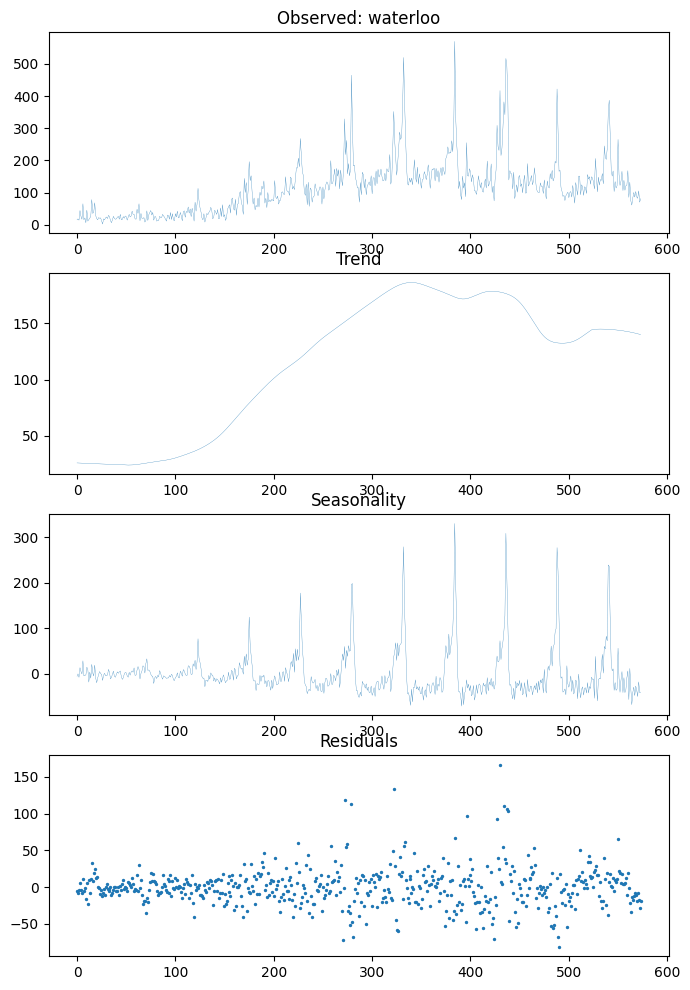

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

matrix_index = vectorizer.vocabulary_['waterloo']
series = stacked_X_grouped[:, matrix_index].toarray().reshape(-1)

# fig = decomposition.plot()
# decomposition = seasonal_decompose(series, model='additive', period=52)
decomposition = STL(series, period=52).fit()

fig, ax = plt.subplots(figsize=(8, 12), nrows=4, ncols=1)
ax[0].set_title(f"Observed: {inverse_vocabulary_[matrix_index]}")
ax[0].plot(series, linewidth=0.2)
ax[1].set_title(f"Trend")
ax[1].plot(decomposition.trend, linewidth=0.2)
ax[2].set_title(f"Seasonality")
ax[2].plot(decomposition.seasonal, linewidth=0.2)
ax[3].set_title(f"Residuals")
ax[3].scatter(np.arange(stacked_X_grouped.shape[0]), decomposition.resid, s=2)



In [ ]:
# r = decomposition.observed - decomposition.trend
r = decomposition.trend
# r = decomposition.observed
from statsmodels.tsa.stattools import adfuller
result = adfuller(r[~np.isnan(r)], maxlag=52)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print(result[2], result[3])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.562831
p-value: 0.502233
52 469
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570


In [ ]:
import numpy as np
import pymannkendall as mk


# result = mk.seasonal_test(series)
result = mk.seasonal_test(series, period=365)
print(result)

Seasonal_Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=24.214174593532906, Tau=0.2946588422518401, s=5925.0, var_s=59853.666666666686, slope=1.3333333333333333, intercept=7.663013698630137)


In [ ]:
result = mk.seasonal_test(series, period=365)
print(result)

Seasonal_Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=26.627414272427327, Tau=0.31838074398249455, s=6402.0, var_s=57788.000000000095, slope=0.3333333333333333, intercept=1.1657534246575343)


(0.0, 1.0)

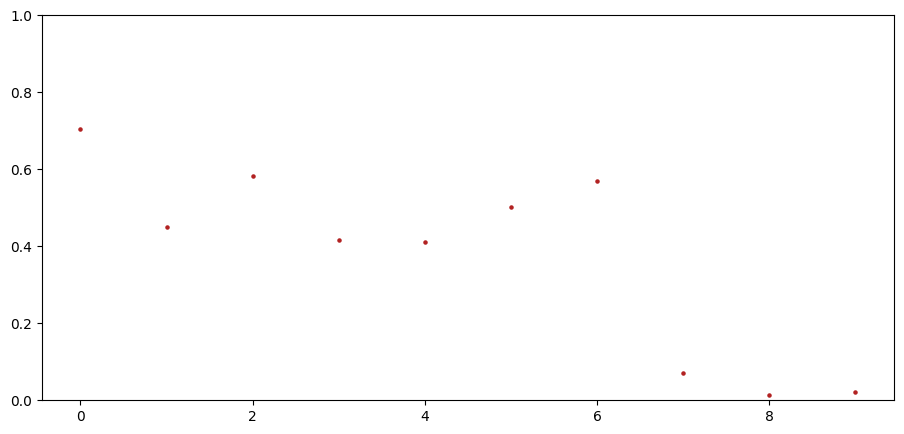

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Load your time series data into a pandas Series

# Perform Ljung-Box test
# Change 12 to your data's seasonal period
# r = acorr_ljungbox(np.random.randn(100))['lb_pvalue']
plt.scatter(np.arange(r.shape[0]), r, s=5, color="firebrick")
plt.ylim([0, 1])

### Fourier transform

In [ ]:
from scipy.fft import fft

fig, ax = plt.subplots(figsize=(10, 6), nrows=4, ncols=5)
for i in range(4):
  for j in range(5):
    matrix_index = top_variances.reshape(4, 5)[i][j]
    series = stacked_X_grouped[:, matrix_index].toarray().reshape(-1)
    # ax[i][j].set_title(f"TFIDF score for: {idf_mapping.loc[matrix_index]['level_0']}", fontsize=8)
    ax[i][j].set_title(f"TFIDF score for: {inverse_vocabulary_[matrix_index]}", fontsize=8)
    # ax[i][j].yaxis.label.set_visible(False)
    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])
    ax[i][j].set(ylabel=None)
    # ax[i][j].plot(
    #     np.expand_dims(np.arange(stacked_X_grouped.shape[0]), axis=-1),
    #     series, linewidth=0.2)
    # ax[i][j].set_ylim([0, series.max()])
    ax[i][j].plot(
        np.expand_dims(np.arange(364), axis=-1),
        fft(series)[1:365], linewidth=0.2, color="firebrick")

In [ ]:
fft(series)[:365]

In [ ]:
np.var(fft(series))

1718403.0000000005

[]

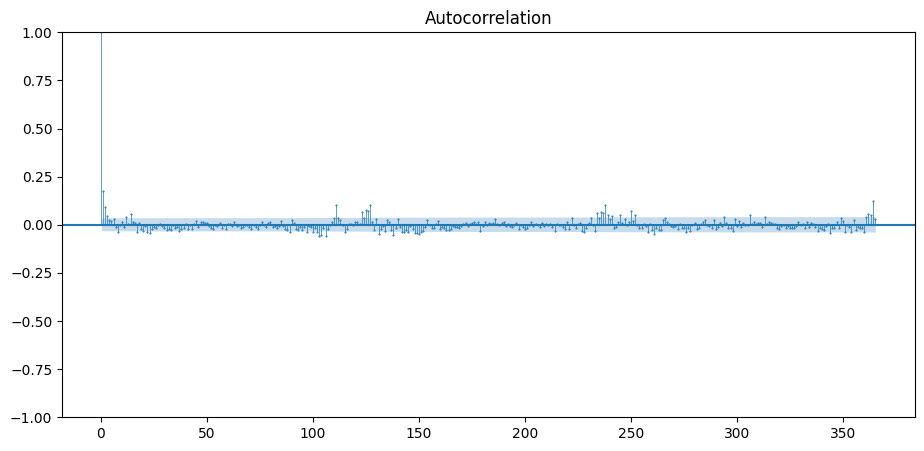

In [ ]:
plot_acf(r[~np.isnan(r)], lags=365, markersize=0.5, vlines_kwargs={"linewidth": 0.5})
plt.plot()

In [ ]:
def sparse_corrcoef(A, B=None):

    if B is not None:
        A = sparse.vstack((A, B), format='csr')

    A = A.astype(np.float64)
    n = A.shape[1]

    # Compute the covariance matrix
    rowsum = A.sum(1)
    centering = rowsum.dot(rowsum.T.conjugate()) / n
    C = (A.dot(A.T.conjugate()) - centering) / (n - 1)

    # The correlation coefficients are given by
    # C_{i,j} / sqrt(C_{i} * C_{j})
    d = np.diag(C)
    coeffs = C / np.sqrt(np.outer(d, d))

    return coeffs

In [ ]:
day_reindex.iloc[20:30]

day_index
20   2012-01-21 00:10:39
21   2012-01-22 00:30:03
22   2012-01-23 00:10:39
23   2012-01-24 00:00:23
24   2012-01-25 00:01:16
25   2012-01-26 00:04:47
26   2012-01-27 00:02:12
27   2012-01-28 00:06:02
28   2012-01-29 00:08:37
29   2012-01-30 00:06:08
Name: created_utc, dtype: datetime64[ns]

In [ ]:
series[np.argmax(series)]

0.9994853728494362

In [ ]:
window_size = 4
windows = list((g[0][0], len(g)) 
    for key, group in it.groupby(enumerate(series > 1.96 * np.std(series)), key=lambda v: v[1]) 
    if key 
    for g in (list(group),))
for w in list(filter(lambda x: x[1] >= window_size, windows)):
  print(day_reindex[w[0]] , w)

In [ ]:
# top_count_days = series.argsort()
week_from, week_to = day_reindex[series.argmax()], day_reindex[series.argmax() + 1]

In [ ]:
selected_week = data_subset_tokens[data_subset_tokens['week_index'] == series.argmax()]
selected_week[selected_week['tokens'].apply(lambda x: 'white' in x)]

,created_utc,tokens,text,author,score,day,week_index
737147,2018-04-22 12:39:27,"[bro, use, eye, test, white, “white”, ain’t, days, saying, irish, ain’t, white, although, probably, conjecture, whether, light, skinned, latinos, arabs, “white”, serbs, though, europeans, thus, white]","Bro use the eye test. If you are white, then you are “white”. This ain’t the days of saying the Irish ain’t white any more. Although there is probably some conjecture over whether some light skinned Latinos and Arabs are “white” or not. Serbs though are Europeans and thus white.",dontshootthattank,1,112,329
737300,2018-04-22 17:05:16,"[feeling, someone, white, knight]",I had a feeling someone would white knight here.,FutureSEdropout,6,112,329
737326,2018-04-22 17:50:27,"[honestly, consent, isn’t, black, white, lot, time, it’s, generally, good, idea, ask, “is, ok, you”, doubt, especially, it’s, someone, you’re, long, term, relationship, involves, like, kissing, keep, pulling, back, example, moving, hand, away, doesn’t, mean, keep, trying]","Honestly consent isn’t just black and white a lot of the time. It’s generally a good idea to ask “is this ok with you” when in doubt.. \n\nEspecially if it’s someone you’re not in a long term relationship with, or it involves more than like kissing\n\nIf they keep pulling back for example, or moving your hand away.. THAT DOESN’T MEAN KEEP TRYING",algejyrr,2,112,329
737537,2018-04-22 22:02:23,"[haha, white, people, things]",haha just white people things~~,TheSnakeThatVapes,-7,112,329
737551,2018-04-22 22:13:17,"[haha, white, people, problems]",Haha white people problems ~~,throwyahway,4,112,329
...,...,...,...,...,...,...,...
744813,2018-04-28 20:52:46,"[gt, know, propaganda, ive, read, sounds, like, rhetoric, propaganda, like, posters, read, thoughts, youll, see, lot, common, gt, literally, believe, increase, immigrants, assume, nonwhite, constitutes, ethnocide, eurocanadian, people, call, isolationist, ethnostate, 80, incoming, immigrants, nonwhite, im, assuming, anything, truth, gt, call, systematic, elimination, foreign, racial, elements, public, life, every, area, must, sanitary, separation, germans, nongermans, racial, grounds, exclusively, nationality, even, religious, belief, see, getting, somewhere, racial, grounds, exclusively, main, focal, point, looking, 100, white, state, ive, told, repeatedly, also, cultural, religious, reasons, far, racial, reasons, see, correlated, former, systematic, elimination, foreign, influence, equivalent, slowing, halting, noneuropean, immigration, become, minority, however, ...]","&gt; I know, because the propaganda I've read sounds just like your rhetoric\n\nPropaganda? Like posters? Read their thoughts. You'll see that you have a lot more in common with them than I do.\n\n&gt; You literally believe the increase of ""immigrants"" (who you assume are non-white) constitutes ""ethnocide"" to your Euro-Canadian people. You call for an isolationist ethnostate. \n\n80% of incoming immigrants are non-white. I'm not ""assuming"" anything other than the truth. \n\n&gt; ""We call for the systematic elimination of foreign racial elements from public life in every area. There must be a sanitary separation between Germans and non-Germans on racial grounds exclusively, not on nationality or even religious belief.""\n\nSee, now we're getting somewhere. \n\n""On racial grounds exclusively"" is their main focal point. I am not looking for a 100% white state, as I've told you repeatedly. I am also doing this for cultural and religious reasons, far more than racial reasons, which I only see as correlated to the former. \n\nThe ""systematic elimination of foreign influence"" is not equivalent to ""the slowing, or halting of non-European immigration so that we do not become a minority"".\n\nYOU, however, have insisted that ""white culture"" is synonymous with ""white supremacy"" , that all whites are racist and so on, and so:\n\n&gt; We call for (and have already begun) the systematic eliminat

In [ ]:
selected = data_subset[(data_subset['created_utc'] > week_from) & (data_subset['created_utc'] < week_to)]
print(selected.count())
selected[selected['text'].apply(lambda x: 'white' in x.lower())]
# pd.to_datetime
# pd.Timestamp(2020, 11, 20, 6, 7)
# pd.Timestamp('2020-11-20 06:07')

In [ ]:
selected

,created_utc,author,text,score
1550436,2020-11-20 00:01:41,_Saraha_,They are just normal hahah,2
1550437,2020-11-20 00:02:16,_Saraha_,These are just generic grass free brownies hahah,3
1550438,2020-11-20 00:02:52,goboatmen,"I live up to plenty of them? I live and breathe in workshop space doing woodwork and metal work, have been camping all my life and owned season tickets for the Toronto Argos just off the top of my head. Doesn't get more traditionally manly than football. I just also don't want these to be exclusively male traits, nor do I think it's healthy that plenty of men would feel self conscious straying from traditionally male roles",2
1550439,2020-11-20 00:04:15,uw-police,lol,3
1550440,2020-11-20 00:04:55,Hello_devraj,is 12.3 the adjustment factor for IB schools in ontario as well? or is it only for IB schools not in ontario?,2
...,...,...,...,...
141578,2020-11-20 20:33:44,rethegreat,I am currently a high school senior deciding which university to go to and I was wondering would you guys recommend this school or not. (Majoring in CS or chemistry),0
141579,2020-11-20 20:35:04,Island_Man89,"Hi all,\n\nI graduated from Waterloo two years ago roughly. I had done a degree in mathematical physics. \n\nBy far the best physics teacher at that university is Richard Epp in my opinion. He was an excellent teacher and able to explain even the most difficult concepts to anyone using their own communication style.\n\nThe reason I’m posting this is because I truly miss his lectures, I still have his notes but I’m wondering if he did video lectures this past year since covid started, and if they are public access by any chance. \n\nI would kill to see one of his lectures again. When I was his student I actually asked him if he would ever record them, but if I recall correctly he didn’t like the idea of deterring students from coming to class.",25
141580,2020-11-20 20:45:05,fluffyballoo,"More restrictions coming in. **Effective Sunday at Midnight (Monday at 00:00)**\n\nSome **key** (read the [link](https://www.ontario.ca/page/covid-19-response-framework-keeping-ontario-safe-and-open#red) for all the restrictions) details on restrictions:\n\n**General**\n\n* Gathering limit for all organized public events and social gatherings:\n * ~~10 people indoors~~ **NOW 5 PEOPLE INDOORS**\n * 25 people outdoors\n* Religious services, weddings and funerals:\n * 30% capacity indoors\n * 100 people outdoors\n\n**Restaurants:**\n\n* Maximum number of patrons permitted to be seated indoors is 10\n* Require patrons to be seated; 2 metre minimum between tables\n* Outdoor dining, take out, drive through, and delivery permitted\n* 4 Person Max per table\n\n**Sports and recreational fitness facilities:**\n\n* Maximum 50 people per facility (revoke OCMOH approved plan) in all combined recreational fitness spaces or programs (not pools, rinks at arenas, community centres, and multi-purpose facilities)\n* Gyms and fitness studios permitted to be open with:\n * 10 people indoors (classes)\n * 25 people outdoors (classes)\n * 10 people indoors (areas with weights or exercise equipment)\n* All sports and recreational programs in other facilities (arenas and multiplexes) limited to 10 people per room indoors and 25 outdoors\n\n&amp;#x200B;\n\nSource: [https://www.ontario.ca/page/covid-19-response-framework-keeping-ontario-safe-and-open#red](https://www.ontario.ca/page/covid-19-response-framework-keeping-ontario-safe-and-open#red)\n\nSource for red zone move: Doug reading off teleprompter\n\n[https://toronto.ctvnews.ca/ontario-expected-to-announce-new-restrictions-for-toronto-peel-region-amid-rising-covid-19-cases-1.5197410](https://toronto.ctvnews.ca/ontario-expected-to-announce-new-restrictions-for-toronto-peel-region-amid-rising-covid-19-cases-1.5197410)",70
141583,2020-11-20 21:44:57,sheriswriting,"Hi all! Feel free to delete if this is not allowed. I’m a reporter at HuffPost Canada, writing about how students feel about online learning at this point in the

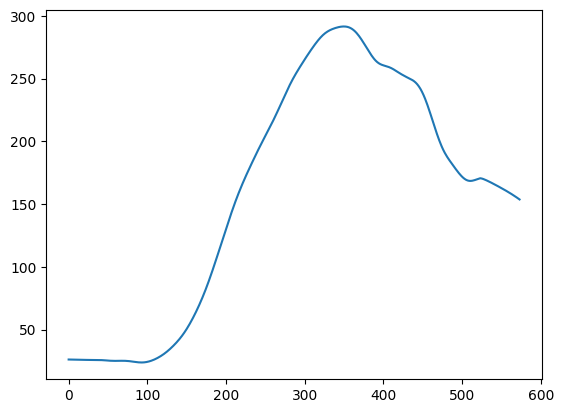

In [ ]:
from statsmodels.tsa.seasonal import STL
STIL_decomposition = STL(series, period=52).fit()
plt.plot(STIL_decomposition.trend)

In [ ]:
%%timeit

decomposition = STL(np.log(series), period=52).fit()

154 ms ± 17.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit

seasonal_decompose(series, period=52)

3.59 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


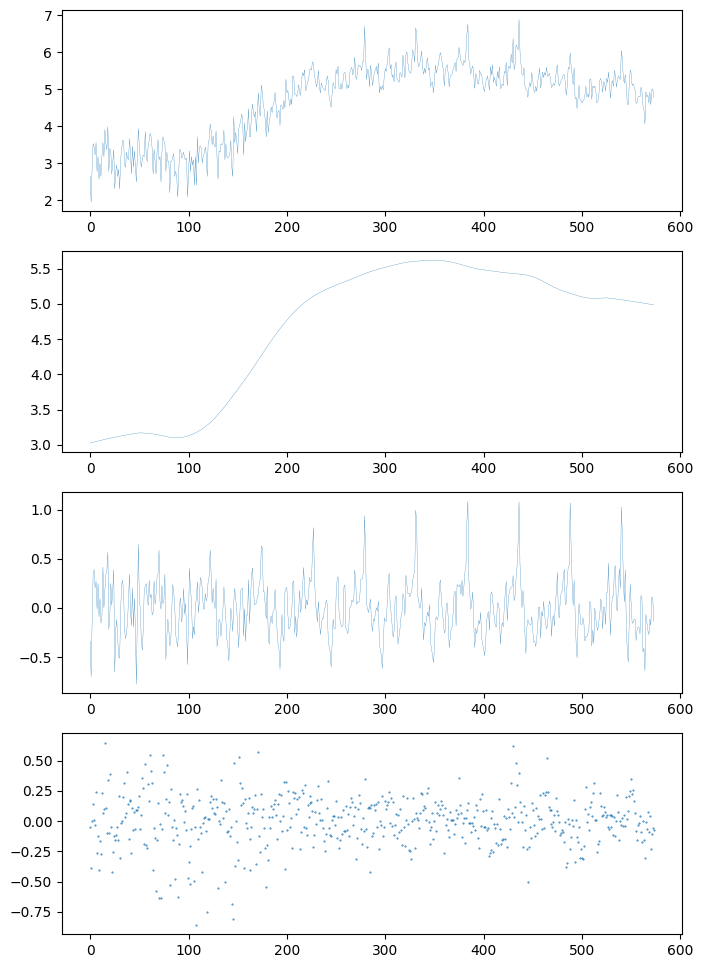

In [ ]:

from statsmodels.tsa.seasonal import seasonal_decompose
# series = pd.Series(X[:, matrix_index].toarray().reshape(-1), index=day_reindex)
series = stacked_X_grouped[:, matrix_index].toarray().reshape(-1)
# decomposition = seasonal_decompose(series, model='additive', period=52)
decomposition = STL(np.log(series), period=52).fit()

# fig = decomposition.plot()
fig, ax = plt.subplots(figsize=(8, 12), nrows=4, ncols=1)
ax[0].plot(decomposition.observed, linewidth=0.2)
ax[1].plot(decomposition.trend, linewidth=0.2)
ax[2].plot(decomposition.seasonal, linewidth=0.2)
ax[3].scatter(np.arange(stacked_X_grouped.shape[0]), decomposition.resid, s=0.2)



# fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True)


# # decomposition.observed.plot(ax=axes[0], legend=False, color='r')
# axes[0].set_ylabel('Observed')
# decomposition.trend.plot(ax=axes[1], legend=False, color='g')
# axes[1].set_ylabel('Trend')
# decomposition.seasonal.plot(ax=axes[2], legend=False)
# axes[2].set_ylabel('Seasonal')
# decomposition.resid.plot(ax=axes[3], legend=False, color='k')
# axes[3].set_ylabel('Residual')

In [ ]:
np.std(series)

0.013498167483739868

In [ ]:
resids = decomposition.resid
resids[~np.isnan(resids)]

array([-0.01117363, -0.01284583,  0.00723881, ..., -0.00772401,
       -0.01066137, -0.01385866])

In [ ]:
import scipy
scipy.stats.shapiro(resids[~np.isnan(resids)])

ShapiroResult(statistic=0.9882197976112366, pvalue=6.86919103328208e-17)

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


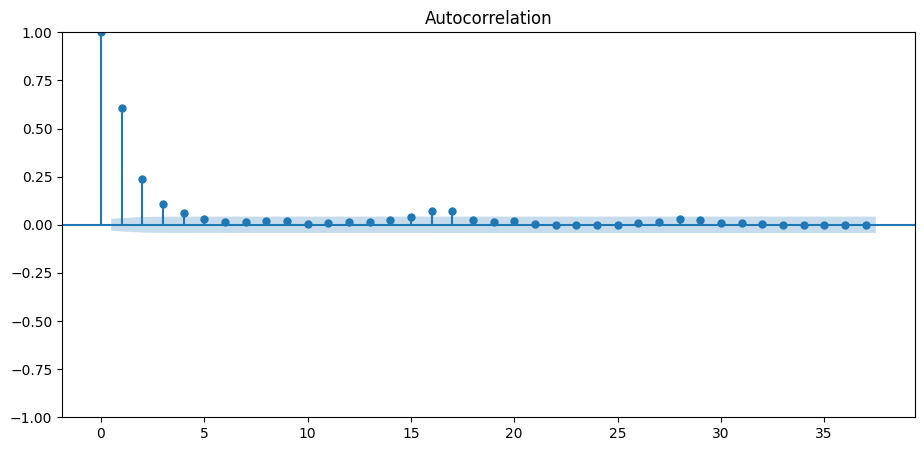

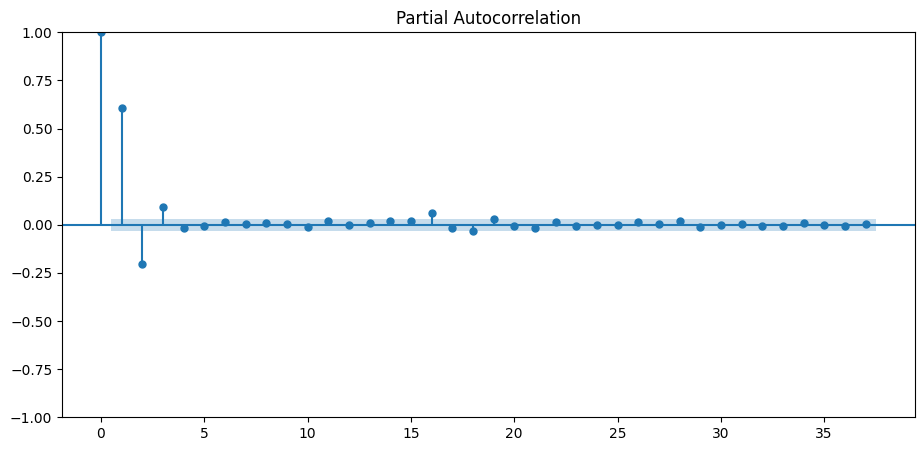

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot autocorrelation
plt.rc("figure", figsize=(11,5))
plot_acf(series)
plot_pacf(series)
plt.show()


In [ ]:
import pymannkendall as mk
import matplotlib.pyplot as plt
import statsmodels.api as sm

print(mk.original_test(X[:, matrix_index].todense(), alpha=0.05))

Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=46.448773774822094, Tau=0.46208853192093996, s=4665140.0, var_s=10087433156.666666, slope=3.0105660106317603e-05, intercept=0.06318452527771373)


In [ ]:
row = 23

tfidf_row_values = X[row].data[top_k_indices[row][0]]
tfidf_row_values.shape

(4084,)

In [ ]:
corresponding_top_tfidf_words = pd.concat([idf_mapping.loc[top_k_indices[row][1]].reset_index(),
           pd.Series(tfidf_row_values, name="tfidf")], axis=1)

corresponding_top_tfidf_words['product'] = corresponding_top_tfidf_words.apply(lambda x: x['idf'] * x['tfidf'], axis=1)

In [ ]:
result = corresponding_top_tfidf_words
quantile = result['idf'].quantile(0.0)
print(result.shape, quantile)
result[result['idf'] > quantile].sort_values(by="tfidf", ascending=False).head(25)
# corresponding_top_tfidf_words[corresponding_top_tfidf_words['idf'] > quantile_value].head(25)

(4084, 5) 1.0


,index,level_0,idf,tfidf,product
14,38943,engineering,1.002743,0.094025,0.094283
22,105760,smartest,2.805553,0.077374,0.217076
36,42685,feminism,3.093235,0.062559,0.193509
42,92149,programs,1.039111,0.055404,0.057571
51,105757,smarter,2.047867,0.052712,0.107948
52,101880,se,1.144155,0.052591,0.060172
56,39055,english,1.082786,0.049770,0.053890
60,74642,math,1.002743,0.047934,0.048066
65,23266,ceca,1.209538,0.046701,0.056486
69,53293,healths,6.206750,0.045646,0.283316


In [ ]:
submissions_df

,subreddit_subscribers,url,edited,num_comments,over_18,link_flair_text,permalink,link_flair_css_class,score,is_self,...,subreddit_id,thumbnail,title,author_flair_text,author_flair_css_class,author,stickied,secure_media_embed,secure_media,gilded
0,0,http://www.ece.uwaterloo.ca/~dwharder/Personal/,False,0,False,None,/r/uwaterloo/comments/a7rhv/harder/,None,2,False,...,t5_2rb5s,default,HARDER,None,None,[deleted],False,{},None,0
1,0,http://www.ece.uwaterloo.ca/People/faculty/leung.html,False,1,False,None,/r/uwaterloo/comments/a7sdl/bosco/,None,2,False,...,t5_2rb5s,NaN,BOSCO,None,None,pussymoney,False,{},None,0
2,0,http://ece.uwaterloo.ca/People/images/hasan.jpg,False,0,False,None,/r/uwaterloo/comments/a7se3/hasan/,None,3,False,...,t5_2rb5s,NaN,HASAN,None,None,pussymoney,False,{},None,0
3,0,http://www.ece.uwaterloo.ca/People/faculty/harder.html,False,1,False,None,/r/uwaterloo/comments/a7sf1/harder/,None,5,False,...,t5_2rb5s,NaN,HARDER,None,None,pussymoney,False,{},None,0
4,0,http://www.ece.uwaterloo.ca/People/faculty/dasiewicz.html,False,1,False,None,/r/uwaterloo/comments/a7sfe/dasiewicz/,None,3,False,...,t5_2rb5s,NaN,DASIEWICZ,None,None,pussymoney,False,{},None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185577,86866,NaN,False,0,False,Social,/r/uwaterloo/comments/1004spl/kyp_podcast_ep_1_giving_up_on_law_school/,social,1,False,...,t5_2rb5s,default,KYP Podcast Ep 1 - Giving up on Law school,None,None,[deleted],False,{},None,0
185578,86866,https://www.reddit.com/r/uwaterloo/comments/1004tp7/kyp_podcast_ep_1_giving_up_on_law_school/,False,0,False,Social,/r/uwaterloo/comments/1004tp7/kyp_podcast_ep_1_giving_up_on_law_school/,social,0,True,...,t5_2rb5s,default,KYP Podcast Ep 1 - Giving up on Law School,None,None,BDK_24,False,{},None,0
185579,86866,https://v.redd.it/fqq1v7s2bb9a1,False,11,False,Humour,/r/uwaterloo/comments/1005ook/my_celebration_of_southern_ontario/,humor,178,False,...,t5_2rb5s,default,My Celebration of Southern Ontario,None,None,CloverHounds,False,{},"{'reddit_video': {'bitrate_kbps': 2400, 'dash_url': 'https://v.redd.it/fqq1v7s2bb9a1/DASHPlaylist.mpd?a=1675759718%2CY2ExOTgwMTc4N2U3NmMwZjFkNGYyZjkxMjgyMTg0NzI2ZDczNWZlYzU3MzgzMTZhZmU0ODBmNmQ4ZTI5YTllZA%3D%3D&amp;v=1&amp;f=sd', 'duration': 168, 'fallback_url': 'https://v.redd.it/fqq1v7s2bb9a1/DASH_720.mp4?source=fallback', 'height': 720, 'hls_url': 'https://v.redd.it/fqq1v7s2bb9a1/HLSPlaylist.m3u8?a=1675759718%2CMDkxOTNkMTA3NTA0YmVhNjkyMmQ5OTE1YWUyMjViNzQxYzRjMjIxZGM0NTMzZTdhNzg0NTcwMTdhMmNmZjlhNw%3D%3D&amp;v=1&amp;f=sd', 'is_gif': False, 'scrubber_media_url': 'https://v.redd.it/fqq1v7s2bb9a1/DASH_96.mp4', 'transcoding_status': 'completed', 'width': 1280}}",0
185580,86866,NaN,1672527498.0,3,False,Admissions,/r/uwaterloo/comments/1005va5/are_extracurriculars_important_for_applying_to/,admissions,0,True,...,t5_2rb5s,default,Are extracurriculars important for applying to waterloo cs as an undergrad?,None,None,[deleted],False,{},None,0


In [ ]:
vectorizer.vocabulary_['types']

117577

In [ ]:
data_2018_tokens[data_2018_tokens['week'] == 26].sort_values('score', ascending=False).head(20)

KeyError: ignored

In [ ]:
quantile_value = idf_mapping['idf'].quantile(0.025)
quantile_value

# Attempt graph based

In [ ]:


vectorizer = TfidfVectorizer()
t1_start = perf_counter()
dot_product = X_title.dot(X_title.T)
# X = vectorizer.fit_transform([' '.join(list(it.chain(*processed_corpus)))])
t1_stop = perf_counter()
print(t1_stop - t1_start)


0.5797355369995785


In [ ]:
dot_product[0].data, dot_product[0].indptr, dot_product[0].indices

(array([1.        , 0.51791556, 0.48705023, 0.54427935, 0.53212135,
        0.51286351, 0.38625811, 0.28347296]),
 array([0, 8], dtype=int32),
 array([    0,  2427,  7858, 10694, 17427, 17445, 23060, 25349],
       dtype=int32))

In [ ]:
mask = (dot_product > 0.6)
print(mask.count_nonzero())
masked_product = dot_product.multiply(mask)

101270


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

G = nx.Graph(masked_product)

In [ ]:
connected_list = []
connected_comps_gen = nx.connected_components(G)

In [ ]:
edges = set()
for connected_comp in tqdm(connected_comps_gen):
  if len(connected_comp) > 1:
    connected_list.append(connected_comp)

19130it [00:00, 47590.97it/s]


<Axes: >

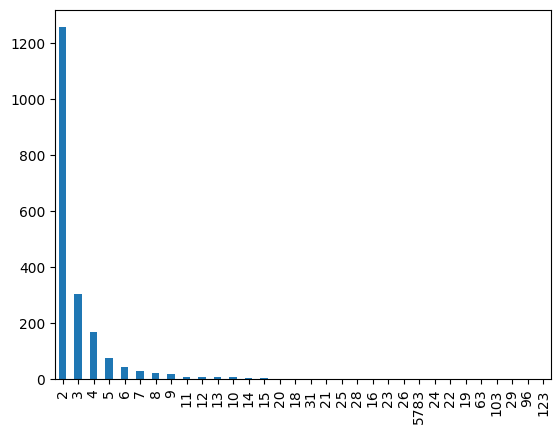

In [ ]:
pd.Series(list(map(len, connected_list))).value_counts().plot(kind="bar")

In [ ]:
big_clusters = list(filter(lambda x: len(x) >= 10, connected_list))

In [ ]:
len(big_clusters)

61

In [ ]:
data_2018_tokens[data_2018_tokens['week'] == 35].sort_values(by="score", ascending=False).head(10)

,created_utc,tokens,title,author,score,num_comments,week
19144,2018-08-30 22:01:31,"[upvote, good, exam, marks, year]",Upvote for good exam marks this year.,stevefrench74,667,17,35
19004,2018-08-28 20:22:26,"[walking, campus]",Walking through campus,Kersheck,556,6,35
18905,2018-08-27 15:10:33,"[every, sixty, minutes, hour, passes]","Every sixty minutes, an hour passes.",ptl-btl,373,22,35
19070,2018-08-29 21:07:42,"[live, society]",We live in a society,SNIPRS,322,12,35
19292,2018-09-02 16:11:10,[honk],honk,SoldOutDates,270,23,35
19040,2018-08-29 12:38:20,"[good, boi, comes, comfort, studying]",A good boi comes to comfort me while studying,Deleriousmexican,254,27,35
19023,2018-08-29 02:32:59,"[dps, final, form]",DP's final form,UnoPlusUno,212,12,35
19149,2018-08-30 23:08:25,"[rip, oweek]",rip oweek,HereComesBrownBoi,160,26,35
19238,2018-09-01 18:27:05,"[yesterday, victoria, park]",Yesterday at Victoria Park,fabulizer,157,11,35
19130,2018-08-30 18:43:56,"[love, life]",I Love Life,uwthrowaway69420,154,21,35


In [ ]:
data_2018_tokens

,created_utc,tokens,title,author,score,num_comments,week
0,2018-01-01 00:18:35,"[adhd, diagnosis]",ADHD Diagnosis??,Salzasuo,9,18,1
1,2018-01-01 01:57:54,"[term, averages, get, rounded]",Do term averages get rounded up?,JKK26,2,5,1
2,2018-01-01 02:28:25,"[realllly, dont, want, start, new, year, failing, course]",I realllly dont want to start the new year off by failing a course,UWcompengStudent,16,8,1
3,2018-01-01 02:51:26,"[math, 127]",MATH 127 :(,backchodBhardwa,51,5,1
4,2018-01-01 02:58:15,[none],H A P P Y N E W Y E A R M Y D U D E S,UnreflectiveHardball,22,3,1
...,...,...,...,...,...,...,...
29516,2018-12-30 22:13:20,"[rate, courses]",Rate these courses!,NapsCrew,4,5,52
29517,2018-12-30 22:50:13,"[transfer, pure, math, cs, advice]",Transfer from pure math to CS advice,sorrowcookie,6,13,52
29518,2018-12-30 22:59:32,"[hiking, update]",Hiking update,TitanCream,11,4,52
29519,2018-12-30 23:03:07,"[mcdouble, vs, junior, chicken]",MCDOUBLE vs JUNIOR CHICKEN,pinoocchio,14,33,52


# Fit LDA model

In [ ]:
t1_start = perf_counter()
ldamodel = gensim.models.ldamodel.LdaModel(masked_data, num_topics=6, id2word = dictionary, passes=20)
t1_stop = perf_counter()

print(t1_stop - t1_start)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


109.52641825300088


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

tf_vectorizer = CountVectorizer()
dtm_tf = tf_vectorizer.fit_transform(custom_modified_corpus)

lda_tf = LatentDirichletAllocation(n_components=10, random_state=0, learning_method="online", max_iter=10)
lda_tf.fit(dtm_tf)

In [ ]:
sent_topics_df = pd.DataFrame()
for i, row_list in tqdm(enumerate(ldamodel[masked_data])):
    row = row_list[0] if ldamodel.per_word_topics else row_list            
    # print(row)
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    # Get the Dominant topic, Perc Contribution and Keywords for each document
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0:  # => dominant topic
            wp = ldamodel.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
        else:
            break

sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

# Add original text to the end of the output
contents = pd.Series(data_2018['title'])
sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
0it [00:00, ?it/s]<ipython-input-201-4bc4bc1f13a5>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-201-4bc4bc1f13a5>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
29521it [01:41, 291.91it/s]


In [ ]:
contrib_results = pd.concat([sent_topics_df[:29521].drop(columns="title"), sent_topics_df[29521:]['title'].reset_index(drop=True)], axis=1)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pd.set_option('display.max_colwidth', None)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
contrib_results.groupby('Dominant_Topic').count()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Perc_Contribution,Topic_Keywords,title
Dominant_Topic,,,
0.0,4672,4672,4672
1.0,4240,4240,4240
2.0,3847,3847,3847
3.0,5196,5196,5196
4.0,7962,7962,7962
5.0,3604,3604,3604


In [ ]:
contrib_results[contrib_results['Dominant_Topic'] == 1].sort_values(by="Perc_Contribution", ascending=False)[:50]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Dominant_Topic,Perc_Contribution,Topic_Keywords,title
1803,1.0,0.9356,"day, crying, free, ama, girl, post, girls, like, today, guy","""Free"" 3-piece Popeyes Chicken Tenders today, with lg drink purch ($2.61) courtesy of Raptors"
1377,1.0,0.9232,"day, crying, free, ama, girl, post, girls, like, today, guy",Do you pee directly into the toilet water and make a big splash or onto the sides so it's quieter?
5543,1.0,0.9164,"day, crying, free, ama, girl, post, girls, like, today, guy",AFSA Tax Clinic Today from 10am - 8pm @SLC Multipurpose Room
2881,1.0,0.9163,"day, crying, free, ama, girl, post, girls, like, today, guy","I'm the guy who made the Dave Tompkins post, back one more time"
6679,1.0,0.9162,"day, crying, free, ama, girl, post, girls, like, today, guy",$79/oz AAA + FREE Gram + FREE Edible + FREE Delivery SabrinasWorld.ca
5975,1.0,0.9157,"day, crying, free, ama, girl, post, girls, like, today, guy",To the guy walking down University Ave near Laurier while brandishing a purple lightsaber
3430,1.0,0.9072,"day, crying, free, ama, girl, post, girls, like, today, guy",dear CLV people that make dog barking noises at 1am
3336,1.0,0.9062,"day, crying, free, ama, girl, post, girls, like, today, guy",Got Dumped on Valentine's Day Feel Sad(girl in CS)(not AMA)
28211,1.0,0.8957,"day, crying, free, ama, girl, post, girls, like, today, guy",I never knew there were so many pet owning lurkers on this sub
17180,1.0,0.8956,"day, crying, free, ama, girl, post, girls, like, today, guy",༼ つ ◕_◕ ༽つ GIVE CHAT ROOM ༼ つ ◕_◕ ༽つ


In [ ]:
sent_topics_df

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Dominant_Topic,Perc_Contribution,Topic_Keywords,title
0,8.0,0.6998,"help, need, crying, vs, uwaterloo, grades, whats, grade, finals, parking",NaN
1,0.0,0.8199,"anyone, term, know, else, coop, like, dont, want, going, feel",NaN
2,0.0,0.4299,"anyone, term, know, else, coop, like, dont, want, going, feel",NaN
3,5.0,0.7000,"math, thread, guys, fuck, job, got, cs, us, think, girls",NaN
4,2.0,0.5500,"midterm, like, post, life, afm, students, exams, waterloo, lost, club",NaN
...,...,...,...,...
85086,NaN,NaN,NaN,Rate these courses!
85087,NaN,NaN,NaN,Transfer from pure math to CS advice
85088,NaN,NaN,NaN,Hiking update
85089,NaN,NaN,NaN,MCDOUBLE vs JUNIOR CHICKEN


In [ ]:
from __future__ import print_function
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary=ldamodel.id2word)
vis

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x  \
topic             
4      0.229336   
3      0.016585   
0      0.109507   
2     -0.111211   
1     -0.105115   
5     -0.139102   

              y  \
topic             
4     -0.078869   
3     -0.127004   
0      0.211754   
2      0.029300   
1     -0.136233   
5      0.101052   

       topics  \
topic           
4           1   
3           2   
0           3   
2           4   
1           5   
5           6   

       cluster  \
topic            
4            1   
3            1   
0            1   
2            1   
1            1   
5            1   

            Freq  
topic             
4      26.112120  
3      18.873371  
0      15.481307  
2      13.870487  
1      13.739174  
5      11.923540  , topic_info=          Term  \
1322    thread   
775         cs   
259     anyone   
374       term   
58    waterloo   
...        ...   
58    waterloo   
372       need   
98     student   
2029     worth   
722       math   

             Freq  \
1322  2852.000000   
775   5698.000000   
259   8315.000000   
374   3493.000000   
58    4895.000000   
...           ...   
58     737.507422   
372    430.756138   
98     397.329929   
2029   319.475628   
722    318.431925   

            Total  \
1322  2852.000000   
775   5698.000000   
259   8315.000000   
374   3493.000000   
58    4895.000000   
...           ...   
58    4895.238177   
372   2345.054465   
98    2170.554249   
2029   619.617633   
722   3547.940766   

     Category  \
1322  Default   
775   Default   
259   Default   
374   Default   
58    Default   
...       ...   
58     Topic6   
372    Topic6   
98     Topic6   
2029   Topic6   
722    Topic6   

      logprob  \
1322  30.0000   
775   29.0000   
259   28.0000   
374   27.0000   
58    26.0000   
...       ...   
58    -4.9474   
372   -5.4851   
98    -5.5659   
2029  -5.7840   
722   -5.7872   

      loglift  
1322  30.0000  
775   29.0000  
259   28.0000  
374   27.0000  
58    26.0000  
...       ...  
58     0.2339  
372    0.4321  
98     0.4287  
2029   1.4642  
722   -0.2841  

[295 rows x 6 columns], token_table=      Topic  \
term          
11        1   
11        2   
11        3   
11        4   
11        5   
...     ...   
721       2   
721       3   
721       4   
721       5   
721       6   

          Freq  \
term             
11    0.002263   
11    0.002263   
11    0.991069   
11    0.002263   
11    0.002263   
...        ...   
721   0.001791   
721   0.001791   
721   0.001791   
721   0.001791   
721   0.001791   

       Term  
term         
11       10  
11       10  
11       10  
11       10  
11       10  
...     ...  
721   youre  
721   youre  
721   youre  
721   youre  
721   youre  

[1434 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 1, 3, 2, 6])

In [ ]:
from __future__ import print_function
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary=ldamodel.id2word)
vis

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.204568 -0.053325       1        1  12.400652
3     -0.081322 -0.257440       2        1  12.057404
7     -0.181071  0.132648       3        1  11.275707
4     -0.064524  0.149547       4        1  10.428082
2      0.100138  0.032701       5        1  10.166441
1      0.078570  0.022555       6        1   9.130526
9      0.079925  0.045024       7        1   9.030942
8      0.096632 -0.012897       8        1   8.915590
5      0.101107 -0.044535       9        1   8.609383
0      0.075114 -0.014277      10        1   7.985272, topic_info=         Term         Freq        Total Category  logprob  loglift
259    anyone  8903.000000  8903.000000  Default  30.0000  30.0000
775        cs  6145.000000  6145.000000  Default  29.0000  29.0000
722      math  3642.000000  3642.000000  Default  28.0000  28.0000
113      help  3350.000000  3350.000000  Default  27.0000  27.0000
37         uw  3421.000000  3421.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
1394  happens   265.814599   270.581318  Topic10  -5.5669   2.5098
746      exam  1395.905683  2397.299188  Topic10  -3.9084   1.9868
112       get   482.728555  5253.611482  Topic10  -4.9703   0.1404
18       cant   345.100298   654.802115  Topic10  -5.3059   1.8871
256   looking   370.657706  1892.934159  Topic10  -5.2345   0.8970

[422 rows x 6 columns], token_table=      Topic      Freq Term
term                      
145       1  0.002043  100
145       2  0.002043  100
145       3  0.002043  100
145       4  0.002043  100
145       5  0.002043  100
...     ...       ...  ...
416       5  0.001647  yet
416       6  0.001647  yet
416       7  0.001647  yet
416       8  0.001647  yet
416       9  0.001647  yet

[3304 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 8, 5, 3, 2, 10, 9, 6, 1])

In [ ]:
from __future__ import print_function
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary=ldamodel.id2word)
vis

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.189281 -0.219067       1        1  12.765262
9      0.041040  0.198475       2        1  12.172482
5      0.258152  0.026548       3        1  11.252424
0      0.043003  0.106735       4        1  10.028977
3     -0.013560  0.201538       5        1   9.823828
4     -0.171734  0.050898       6        1   9.573726
7     -0.085337 -0.139198       7        1   9.140131
1      0.034036 -0.075007       8        1   8.896083
2     -0.131232 -0.020786       9        1   8.373398
6     -0.163649 -0.130136      10        1   7.973689, topic_info=       Term         Freq        Total Category  logprob  loglift
41   anyone  1654.000000  1654.000000  Default  30.0000  30.0000
105      cs  1120.000000  1120.000000  Default  29.0000  29.0000
153    coop  1136.000000  1136.000000  Default  28.0000  28.0000
106    help   629.000000   629.000000  Default  27.0000  27.0000
603  thread   583.000000   583.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
295   right   107.205004   145.349097  Topic10  -4.6045   2.2246
629     got   154.254002   319.647826  Topic10  -4.2406   1.8004
375    like    91.872974   559.422046  Topic10  -4.7588   0.7225
154    good    77.843720   386.311780  Topic10  -4.9245   0.9271
3       get    84.483358   989.639231  Topic10  -4.8427   0.0682

[430 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
345       5  0.996644      101
178       5  0.975376      102
396       5  0.991830      135
397       5  0.990932      137
193       1  0.992487       1a
...     ...       ...      ...
3700      5  0.990576   worked
533       6  0.996329  working
633       9  0.995758    worth
13        1  0.997237     year
31       10  0.988378    years

[481 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 10, 6, 1, 4, 5, 8, 2, 3, 7])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Word2vec



In [ ]:
import gensim.downloader

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# LDA with pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml import Pipeline
from pyspark.ml.clustering import LDA

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("LDA Example") \
    .getOrCreate()

# Load dataset
data_path = "uwaterloo_submissions.csv"  # Replace with the path to your dataset
df_submissions_spark = spark.read.csv(data_path, header=True, inferSchema=True).filter("title is not null")

# Create a custom StopWordsRemover with isalpha() filtering
class CustomStopWordsRemover(StopWordsRemover):
    def _transform(self, dataset):
        stopwords = self.getStopWords()
        stopwords_set = set(stopwords) | set(stop_words)

        @udf(returnType=ArrayType(StringType()))
        def filter_words(words):
            return [w for w in words if w not in stopwords_set and w.isalpha() and len(w) > 1]

        return dataset.withColumn(self.getOutputCol(), filter_words(dataset[self.getInputCol()]))
    
# Preprocess text data
tokenizer = Tokenizer(inputCol="title", outputCol="tokens")
remover = CustomStopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
count_vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="raw_features")
idf = IDF(inputCol="raw_features", outputCol="features")

# Build the pipeline
preprocessing_pipeline = Pipeline(stages=[tokenizer, remover, count_vectorizer, idf])
preprocessing_model = preprocessing_pipeline.fit(df_submissions_spark)
preprocessed_data = preprocessing_model.transform(df_submissions_spark)

# Train LDA model
num_topics = 40
lda = LDA(k=num_topics, seed=1, featuresCol="features")
lda_model = lda.fit(preprocessed_data)

# Show the topics
topics = lda_model.describeTopics(maxTermsPerTopic=5)
print("The topics described by their top-weighted terms:")

vocab = preprocessing_model.stages[2].vocabulary

# Define a helper function to map term indices to words
def term_indices_to_words(term_indices):
    return [vocab[int(index)] for index in term_indices]

# Convert term indices to actual words
topics_with_words = topics.rdd.map(lambda row: (row.topic, term_indices_to_words(row.termIndices), row.termWeights)).toDF(["topic", "words", "weights"])
print("The topics described by their top-weighted terms:")

In [ ]:
# Add this import at the beginning of the script
import csv

# Replace the following lines
# Convert term indices to actual words
topics_with_words = topics.rdd.map(lambda row: (row.topic, term_indices_to_words(row.termIndices), row.termWeights)).toDF(["topic", "words", "weights"])

# With
# Convert term indices to actual words and save to CSV
with open("lda_topics.csv", "w", newline='', encoding='utf-8') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(["topic", "words", "weights"])

    for row in topics.rdd.collect():
        topic = row.topic
        words = term_indices_to_words(row.termIndices)
        weights = row.termWeights
        csv_writer.writerow([topic, " ".join(words), " ".join(map(str, weights))])


In [ ]:
num_topics = 20
lda = LDA(k=num_topics, seed=1, featuresCol="features", maxIter=40)
lda_model = lda.fit(processed_data)

# 317 seconds for maxiter = 40

In [ ]:
model.stages[2].vocabulary

In [ ]:
# Show the topics
topics = lda_model.describeTopics(maxTermsPerTopic=20)

vocab = model.stages[2].vocabulary

# Define a helper function to map term indices to words
def term_indices_to_words(term_indices):
    return [vocab[int(index)] for index in term_indices]

topics_with_words = topics.rdd.map(lambda row: (row.topic, term_indices_to_words(row.termIndices), row.termWeights)).toDF(["topic", "words", "weights"])
print("The topics described by their top-weighted terms:")

The topics described by their top-weighted terms:


In [ ]:
topics_with_words

DataFrame[topic: bigint, words: array<string>, weights: array<double>]

In [ ]:
topics_with_words.show(truncate=False)

+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|words                                                                                                                                                                     |weights                                                                                                                                                                                        

# KMeans TFIDF 

In [ ]:



# Initialize Spark session
spark = SparkSession.builder \
    .appName("KMeans Clustering with TF-IDF") \
    .getOrCreate()

# Load CSV file
# data = spark.read.csv("uwaterloo_comments.csv", header=True, inferSchema=True).filter("body is not null")
data = spark.read.option("parserLib", "univocity").option("multiLine", "true").csv("uwaterloo_submissions.csv", header=True)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
data.count()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


187958

In [ ]:
submissions_df.shape

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(185582, 28)

In [ ]:
data.show()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


+---------------------+--------------------+------+------------+-------+---------------+--------------------+--------------------+-----+-------+-----+--------------------+-----+-----------+--------------------+-------------+-------------------+---------+------------+---------+--------------------+-----------------+----------------------+-----------+--------+------------------+------------+------+
|subreddit_subscribers|                 url|edited|num_comments|over_18|link_flair_text|           permalink|link_flair_css_class|score|is_self|   id|            selftext|media|media_embed|              domain|distinguished|        created_utc|subreddit|subreddit_id|thumbnail|               title|author_flair_text|author_flair_css_class|     author|stickied|secure_media_embed|secure_media|gilded|
+---------------------+--------------------+------+------------+-------+---------------+--------------------+--------------------+-----+-------+-----+--------------------+-----+-----------+-----------

In [ ]:
from pyspark.sql.functions import *

start_time = "2018-01-01 00:00:01"
end_time = "2018-12-31 23:59:59"

# data_2018 = data.filter(year(from_unixtime(col("created_utc"))) == 2017)
# For comments
# data_2018 = data.filter(from_unixtime(col("created_utc")).between(start_time, end_time))

# For submissions
data_2018_spark = data.filter(year(col("created_utc")) == 2018)
data_2018_spark.cache()
# data_2018 = data.filter("body is not null")

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


DataFrame[subreddit_subscribers: string, url: string, edited: string, num_comments: string, over_18: string, link_flair_text: string, permalink: string, link_flair_css_class: string, score: string, is_self: string, id: string, selftext: string, media: string, media_embed: string, domain: string, distinguished: string, created_utc: string, subreddit: string, subreddit_id: string, thumbnail: string, title: string, author_flair_text: string, author_flair_css_class: string, author: string, stickied: string, secure_media_embed: string, secure_media: string, gilded: string]

In [ ]:
data_2018_spark.count()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


28271

In [ ]:
# data_2018.select(from_unixtime(col('created_utc')).alias("datetime"), "body").show(10)
data_2018_spark.select((col('created_utc')).alias("datetime"), "title").show(15, truncate=False)

+-------------------+----------------------------------------------------------------------------+
|datetime           |title                                                                       |
+-------------------+----------------------------------------------------------------------------+
|2018-01-01 00:18:35|ADHD Diagnosis??                                                            |
|2018-01-01 01:57:54|Do term averages get rounded up?                                            |
|2018-01-01 02:28:25|I realllly dont want to start the new year off by failing a course          |
|2018-01-01 02:51:26|MATH 127 :(                                                                 |
|2018-01-01 02:58:15|H A P P Y N E W Y E A R M Y D U D E S                                       |
|2018-01-01 03:26:04|Looking for some advice on trying to be more productive and manage time well|
|2018-01-01 05:02:35|Happy New Year my dude!                                                     |
|2018-01-0

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class CustomTokenizer(Tokenizer):
    def _transform(self, dataset):
        import string, re
        non_space_whitespace = string.whitespace.replace(" ", "")

        @udf(returnType=ArrayType(StringType()))
        def remove_punctuation_and_tokenize(text):
            # Remove punctuation
            cleaned_text = text.lower().translate(str.maketrans('', '', string.punctuation))
            # cleaned_text = cleaned_text.translate(str.maketrans('', '', string.digits))
            cleaned_text = re.sub(f"[{non_space_whitespace}]", " ", cleaned_text)
            
            # Tokenize (split by whitespace)
            tokens = cleaned_text.split()
            
            return tokens
        
        return dataset.withColumn(self.getOutputCol(), remove_punctuation_and_tokenize(dataset[self.getInputCol()]))



# Tokenize the text column (replace 'text_column' with the name of the column containing text data)
tokenizer = CustomTokenizer(inputCol="title", outputCol="tokens")

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class CustomStopWordsRemover(StopWordsRemover):
    def _transform(self, dataset):
        stopwords = self.getStopWords()
        stopwords_set = set(stopwords) | set(stop_words)

        @udf(returnType=ArrayType(StringType()))
        def filter_words(words):
          filtered_tokens = []
          for w in words:
            if (w not in stopwords_set and 
                len(w) > 1):
              filtered_tokens.append(w)
          if len(filtered_tokens) < 1:
            filtered_tokens.append('none')
          return filtered_tokens
          
        return dataset.withColumn(self.getOutputCol(), filter_words(dataset[self.getInputCol()]))

# Remove stopwords
remover = CustomStopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
2 ** 10

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1024

In [ ]:

# Calculate term frequencies

# ~87335 features for 2018 comments, ~94514 with digits
# 16194 features for 2018 title
# count_vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="raw_features")
hashing_tf = HashingTF(inputCol="filtered_tokens", outputCol="raw_features")
# hashing_tf.setNumFeatures(2 ** 17)
# Calculate the inverse document frequencies
idf = IDF(inputCol="raw_features", outputCol="features", minDocFreq=1.0)

normalizer = Normalizer(inputCol="features", outputCol="normFeatures")

# # First to compute the IDF vector and second to scale the term frequencies by IDF.
# tf.cache()
# idf = IDF().fit(tf)
# tfidf = idf.transform(tf)

# # spark.mllib's IDF implementation provides an option for ignoring terms
# # which occur in less than a minimum number of documents.
# # In such cases, the IDF for these terms is set to 0.
# # This feature can be used by passing the minDocFreq value to the IDF constructor.
# idfIgnore = IDF(minDocFreq=2).fit(tf)

# Create a pipeline with the steps
pipeline = Pipeline(stages=[tokenizer, remover, hashing_tf, idf, normalizer])
# pipeline = Pipeline(stages=[tokenizer, remover, count_vectorizer])


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Fit the pipeline to the data
model = pipeline.fit(data_2018_spark)

# Transform the data
processed_data = model.transform(data_2018_spark)

# Show the results 
processed_data.show(truncate=False)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


+---------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------+------------+------------+-------+---------------+-------------------------------------------------------------------------------+--------------------+-----+-------+------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
num_clusters = 10

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
kmeans = KMeans(k=num_clusters, featuresCol="normFeatures", predictionCol="cluster", distanceMeasure="cosine", maxIter=100)
fitted_model = kmeans.fit(processed_data)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
fitted_model.setPredictionCol("prediction")

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KMeansModel: uid=KMeans_dc7c9d0c616a, k=10, distanceMeasure=cosine, numFeatures=262144

In [ ]:
transformed_data = fitted_model.transform(processed_data)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
transformed_data.show(10)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


+---------------------+--------------------+------+------------+-------+---------------+--------------------+--------------------+-----+-------+------+--------------------+-----+-----------+--------------------+-------------+-------------------+---------+------------+---------+--------------------+--------------------+----------------------+--------------------+--------+------------------+------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|subreddit_subscribers|                 url|edited|num_comments|over_18|link_flair_text|           permalink|link_flair_css_class|score|is_self|    id|            selftext|media|media_embed|              domain|distinguished|        created_utc|subreddit|subreddit_id|thumbnail|               title|   author_flair_text|author_flair_css_class|              author|stickied|secure_media_embed|secure_media|gilded|              tokens|     filtered_tokens|        raw_featu

In [ ]:
evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="normFeatures", distanceMeasure="cosine")
evaluator.evaluate(transformed_data)


0.09678915256458556

In [ ]:

# KMeans clustering

for i in range(10, 35, 5):
  num_clusters = i
  kmeans = KMeans(k=num_clusters, featuresCol="normFeatures", predictionCol="cluster", distanceMeasure="cosine", maxIter=100)
  print(f"Fitting model for clusters {i}")
  fitted_model = kmeans.fit(clustered_data)
  fitted_model.setPredictionCol("prediction")
  transformed_data = fitted_model.transform(clustered_data)

  evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="normFeatures", distanceMeasure="cosine")
  print("Evaluating ...")
  score = evaluator.evaluate(transformed_data)
  print(f"Score: {score}, {1 - score}")
  print("\n\n")

Fitting model for clusters 10
Evaluating ...
Score: 0.09678915256458556, 0.9032108474354145



Fitting model for clusters 15
Evaluating ...
Score: 0.09478703509385993, 0.9052129649061401



Fitting model for clusters 20
Evaluating ...
Score: 0.11387305859234614, 0.8861269414076538



Fitting model for clusters 25
Evaluating ...
Score: 0.11605202256421471, 0.8839479774357852



Fitting model for clusters 30
Evaluating ...
Score: 0.11917271804757809, 0.8808272819524219





In [ ]:
transformed_data.filter("prediction = 9").select("title", "prediction","score", "num_comments", "selftext", "author").show(30, truncate=False)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+-----+------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
 from pyspark.ml.evaluation import ClusteringEvaluator

 evaluator = ClusteringEvaluator(predictionCol="cluster", featuresCol="normFeatures", distanceMeasure="cosine")
 evaluator.evaluate(clustered_data)

0.06500481114867755

In [ ]:
# Stop the Spark session
spark.stop()

In [ ]:
pipeline = Pipeline(stages=[tokenizer, remover])
model = pipeline.fit(data)
transformed_data = model.transform(data)

In [ ]:
transformed_data.select("tokens", "filtered_tokens").show(40, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------+
|tokens                                                                                                                                                                                                       |filtered_tokens                                                                                                                         |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------

In [ ]:
!pip install colab-xterm
%load_ext colabxterm
%xterm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 KB 10.7 MB/s eta 0:00:00


Launching Xterm...

<IPython.core.display.Javascript object>